# Data

## AWID3 Dataset

AWID3 dataset consists of 13 captures of traffic in a wireless network. Of these 7 that focus on attacks on IEEE 802.11 MAC layer. The attacks chosen are: 

* Deauth
* Disass
* (Re)Assoc
* RogueAP
* Krack
* Kr00k
* Evil Twin

## Data preprocessing

For training of the model 

Features selection was based on [Pick Quality Over Quantity: Expert Feature Selection and Data Preprocessing for 802.11 Intrusion Detection Systems](https://ieeexplore.ieee.org/document/9797689) by the authors of the AWID3 dataset:

### Features chosen by Chatzoglou et. al. and their preprocessing

| Feature                    | Preprocessing    |
|----------------------------|------------------|
| frame.len                  | Min-Max Scaling  |
| radiotap.len               | Min-Max Scaling  |
| radiotap.dbm_antsignal     | Min-Max Scaling  |
| wlan.duration              | Min-Max Scaling  |
| radiotap.present.tsft      | One Hot Encoding |
| radiotap.channel.freq      | One Hot Encoding |
| radiotap.channel.type.cck  | One Hot Encoding |
| radiotap.channel.type.ofdm | One Hot Encoding |
| wlan.fc.type               | One Hot Encoding |
| wlan.fc.subtype            | One Hot Encoding |
| wlan.fc.ds                 | One Hot Encoding |
| wlan.fc.frag               | One Hot Encoding |
| wlan.fc.retry              | One Hot Encoding |
| wlan.fc.pwrmgt             | One Hot Encoding |
| wlan.fc.moredata           | One Hot Encoding |
| wlan.fc.protected          | One Hot Encoding |

The chosen features were prepocessed with following differences:
* frame.delta_time was was was added, as it is crucial for analyzing temproal patterns.
* features expressed by 0/1 values, such as IEEE 802.11 Frame Control flags were left unchanged (e.g. frag, retry), not One Hot Encoded as in above mentioned article.
* the authors  One Hot Encoding of channel frequencies, however such approach is only feasable, when there rather few categories (3 frequencies were used in the above mentioned files), so a more genral method of preprocessing frequncy is proposed:
    * create two binary features `2ghz_spectrum` and `5ghz_spectrum` to indicate in which band a frame was sent
    * apply Min-Max Scaling to frequency, using the highest and the lowest channel frequency in given band as Min and Max values, as seen below

In [1]:
def preporcess_frequency(radiotap_channel_freq):
    lower_2ghz, higher_2ghz = 2412, 2472
    lower_5ghz, higher_5gzh = 5160, 5885
    
    if (lower_2ghz <= radiotap_channel_freq <= higher_2ghz):
        _2ghz_spectrum = 1
        _5gzh_spectrum = 0
        freq = (radiotap_channel_freq - lower_2ghz) / (higher_2ghz - lower_2ghz)
    elif (lower_5ghz <= radiotap_channel_freq <= higher_5ghz):
        _2ghz_spectrum = 0
        _5gzh_spectrum = 1
        freq = (radiotap_channel_freq - lower_5ghz) / (higher_5ghz - lower_5ghz)
    else:
        _2ghz_spectrum = 0
        _5gzh_spectrum = 0
        freq = -1
        
    return _2ghz_spectrum, _5gzh_spectrum, freq
     

### Features and used preprocessing

| Feature                   | Type        | Preprocessing       | Values                    | Description                                                                                                       |
|---------------------------|-------------|---------------------|---------------------------|-------------------------------------------------------------------------------------------------------------------|
| frame.len                 | numeric     | Min-Max Scaling     | from 70 to 3220           | Length of frame, in bytes                                                                                         |
| frame.time_delta          | numeric     | Min-Max Scaling     | from 0 to 0.001817        | Time interval since previous frame, in seconds                                                                    |
| radiotap.len              | numeric     | Min-Max Scaling     | from 48 to 64             | Length of Radiotap header, in bytes                                                                               |
| radiotap.dbm_antsignal    | numeric     | Min-Max Scaling     | form -255 to -78          | Strength of recieved signal, in dBm. In AWID3 CSV files the value was summarized for antennas, hence very low values |
| wlan.duration             | numeric     | Min-Max Scaling     | from 0 to 726             | Duration/Id field in IEEE 802.11 header                                                                           |
| wlan.fc.type              | categorical | One Hot Encoding    | 0, 1, 2                   | IEEE 802.11 frame type: Management, Control or Data                                                               |
| wlan.fc.subtype           | categorical | One Hot Encoding    | 0, 1, ... 14, 15          | IEEE 802.11 frame subtype                                                                                         |
| wlan.fc.ds                | categorical | One Hot Encoding    | 0, 1, 2, 3                | Indicates whete a frame was sent to (tods) or from (fromds) a Distribution System (ds), neither or both           |
| radiotap.present.tsft     | binary      | convert to 0,1      | '0-0-0', '1-0-0'          | Presence of TSFT (Time Synchroniztion Function) in Radiotap header                                                |
| radiotap.channel.type.cck | binary      | None                | 0, 1                      | Whether frame was sent using CCK (Complemantary Code Keying), used in IEEE 802.11b                                |
| radiotap.channel.type.ofdm | binary     | None                | 0, 1                      | Whether frame was sent using OFDM (Orthognal Frequency Division Multiplexing) modulation                          |
| wlan.fc.frag              | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame was fragmented                                                         |
| wlan.fc.retry             | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame is retransmission of a previous frame                                  |
| wlan.fc.pwrmgt            | binary      | None                | 0, 1                      | Frame Control flag, used when station enters power management state                                               |
| wlan.fc.moredata          | binary      | None                | 0, 1                      | Frame Control flag, indicates that AP has buffered for the station                                                |
| wlan.fc.protected         | binary      | None                | 0, 1                      | Frame Control flag, indicates that frame has been encrypted                                                       |
| 2ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 2.4GHz band                                                               |
| 5ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 5GHz band                                                                 |
| freq                      | numeric     | As described above  | from 0 to 1               | Frequency scaled for the band station works in                                                                    |
| Label                     | Categorical | Convert to 0, 1, 2  | 'Normal' and attacks      | Label of given to the frame                                                                                      | 

Minimal and maximal values for ranges were estimated accros all AWID3 files, IQR was used to exckude otliers, that were then clipped into range 0, 1.

The traffic was divided into 3 classes:

Classes:

| Class | name           | Attacks                                                               |
|-------|----------------|-----------------------------------------------------------------------|
| 0     | normal         |                                                                       |
| 1     | flooding       | Deauth, Disass, (Re)Assoc, Kr00k                                      |
| 2     | impersonation  | RogueAP, Krack, Evil Twin                                             |

Both binary, and multiclass classificators were trained and evaluated on the dataset.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np

tfrecords_dir='dataset/AWID3_tfrecords'
tfrecords_balanced_dir='dataset/AWID3_tfrecords_balanced'

sequence_length = 128
sequence_shift = 120
n_features = 39

from collections import defaultdict

In [2]:
import data_utils

files = os.listdir(tfrecords_dir)

train_ratio = 0.8
train_files, test_files = data_utils.train_test_split(files, train_ratio=train_ratio)
train_files, val_files = data_utils.train_test_split(train_files, train_ratio=train_ratio)

print("Training set:")
for t in train_files:
    print(t.split('.')[0], end=', ')

print("\nValidation set:")
for t in val_files:
    print(t.split('.')[0], end=', ')

print("\nTest set:")
for t in test_files:
    print(t.split('.')[0], end=', ')
    
train_seq_files = [os.path.join(tfrecords_dir, f) for f in train_files]
val_seq_files = [os.path.join(tfrecords_dir, f) for f in val_files]
test_seq_files = [os.path.join(tfrecords_dir, f) for f in test_files]
train_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in train_files]
val_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in val_files]
test_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in test_files]



Training set:
Deauth_26, Evil_Twin_45, Disas_34, Evil_Twin_61, Disas_31, Kr00k_53, (Re)Assoc_35, Evil_Twin_41, Evil_Twin_66, Disas_35, Deauth_31, Disas_40, Kr00k_40, Evil_Twin_52, (Re)Assoc_32, Kr00k_37, (Re)Assoc_22, Kr00k_42, Deauth_27, Evil_Twin_53, Evil_Twin_64, Evil_Twin_58, (Re)Assoc_30, RogueAP_26, (Re)Assoc_26, Evil_Twin_37, (Re)Assoc_29, Kr00k_41, Deauth_32, Kr00k_34, Evil_Twin_42, Evil_Twin_57, RogueAP_36, Kr00k_44, Kr00k_33, Evil_Twin_72, Evil_Twin_69, Evil_Twin_50, Evil_Twin_35, Kr00k_32, (Re)Assoc_36, Kr00k_57, Evil_Twin_65, Krack_27, Evil_Twin_74, Deauth_22, Evil_Twin_46, Deauth_30, Kr00k_47, (Re)Assoc_34, Evil_Twin_39, RogueAP_33, Evil_Twin_51, Evil_Twin_67, (Re)Assoc_33, Deauth_23, Kr00k_54, RogueAP_35, Kr00k_48, Evil_Twin_60, Disas_38, Kr00k_31, Disas_36, Disas_30, Deauth_21, Disas_29, Evil_Twin_55, Evil_Twin_36, Evil_Twin_49, RogueAP_38, Kr00k_55, Kr00k_35, Evil_Twin_62, Evil_Twin_32, Evil_Twin_71, Evil_Twin_33, RogueAP_34, (Re)Assoc_31, Krack_28, (Re)Assoc_28, Evil_T

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns

# functions for plotting and confusion matrix

def score_and_confusion_matrix(y_pred, y_true, title : str, binary = True, average='binary'):
    class_names = [
        'Normal', 'Attack'
    ] if binary else [
        'Normal', 'Flooding', 'Impersonation'
    ]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f'Accuracy: {100*accuracy:2.3f}%')
    print(f'Precision: {100*precision:2.3f}%')
    print(f'Recall: {100*recall:2.3f}%')
    print(f'F1 : {f1:.5f}')
    print(f'Kappa: {kappa:.5f}')
    
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    
    return accuracy, precision, recall, f1, kappa
    
def plot_model_history(history, title):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title)
    
    if 'accuracy' in history:
        axes[0, 0].plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
    
    # Plot Precision
    if 'precision' in history:
        axes[0, 1].plot(history['precision'], label='Train Precision')
        if 'val_precision' in history:
            axes[0, 1].plot(history['val_precision'], label='Val Precision')
        axes[0, 1].set_title('Precision')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].legend()
    
    if 'recall' in history:
        axes[1, 0].plot(history['recall'], label='Train Recall')
        if 'val_recall' in history:
            axes[1, 0].plot(history['val_recall'], label='Val Recall')
        axes[1, 0].set_title('Recall')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].legend()
    
    if 'loss' in history:
        axes[1, 1].plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[1, 1].plot(history['val_loss'], label='Val Loss')
        axes[1, 1].set_title('Loss')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()    
    plt.tight_layout()
    plt.show()
        

In [5]:
import binary_cnn_lstm
import data_utils

bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()

if not bin_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[binary_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Binary CNN-LSTM")
    print(history)
    #loading best checkpoint
    bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()
    
bin_cnn_lstm_model.name = 'bin_CNN_LSTM'    
bin_cnn_lstm_model.summary()


Model loaded from saved_models/binary_cnn_lstm.keras


Model: "bin_CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 64)       │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 48)       │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 32)       │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,781 (194.46 KB)

 Trainable params: 16,593 (64.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,188 (129.64 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


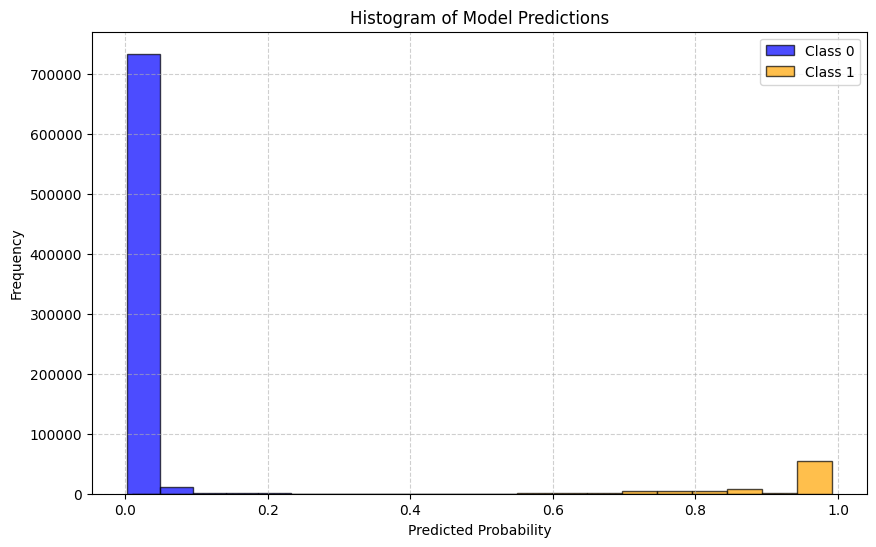

Accuracy: 99.853%
Precision: 98.983%
Recall: 99.517%
F1 : 0.99249
Kappa: 0.99168


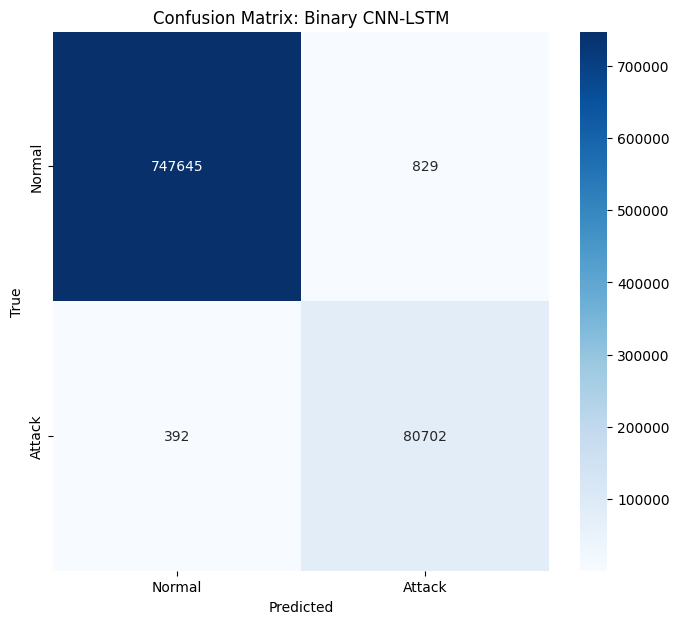

In [6]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features).flatten()
y_true = labels.numpy().flatten()
y_pred = (y_pred > 0.5).astype(int)
    
bin_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-LSTM")


In [8]:
import binary_td_cnn
import data_utils

bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()

if not bin_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[binary_td_cnn.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary Time Domain CNN")
    #loading best checkpoint
    bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()
    
bin_td_cnn_model.name = 'bin_TD_CNN'    
bin_td_cnn_model.summary()

Model loaded from saved_models/binary_td_cnn.keras


Model: "bin_TD_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         3,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 16)       │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 8)        │           904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 4)        │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 1)        │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,341 (87.27 KB)

 Trainable params: 7,409 (28.94 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 14,820 (57.89 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Accuracy: 99.728%
Precision: 99.032%
Recall: 98.174%
F1 : 0.98601
Kappa: 0.98450


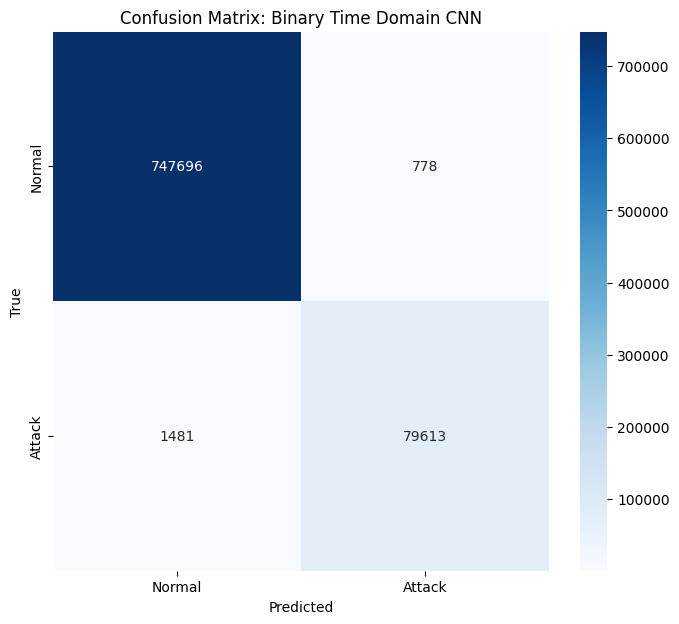

In [9]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_td_cnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary Time Domain CNN")


In [10]:
import binary_cnn_gru
import data_utils

bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model() 

if not bin_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        bin_td_cnn_model,
        dataset_lambda,
        epochs_per_step=3,
        training_callbacks=[bin_cnn_gru_model.checkpoint_callback],
        n_initial_files = 10,
        increment = 0.5
        
    )
    history = {}
    for h in histories:
        for metric, values in h.items():
            if not history[metric]:
                history[metric] = values
            else:
                history[metric].extend[values] 
    
    plot_model_history(history, "Binary CNN")
    #loading best checkpoint
    bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model()
    
    
bin_cnn_gru_model.summary()
bin_cnn_gru_model.name = 'binary_CNN_GRU'

Model loaded from saved_models/binary_cnn_gru.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 48)       │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 32)       │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 24)       │         4,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 12)       │           300 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 1)        │            13 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,933 (93.49 KB)

 Trainable params: 7,977 (31.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,956 (62.33 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Accuracy: 99.834%
Precision: 99.130%
Recall: 99.177%
F1 : 0.99154
Kappa: 0.99062


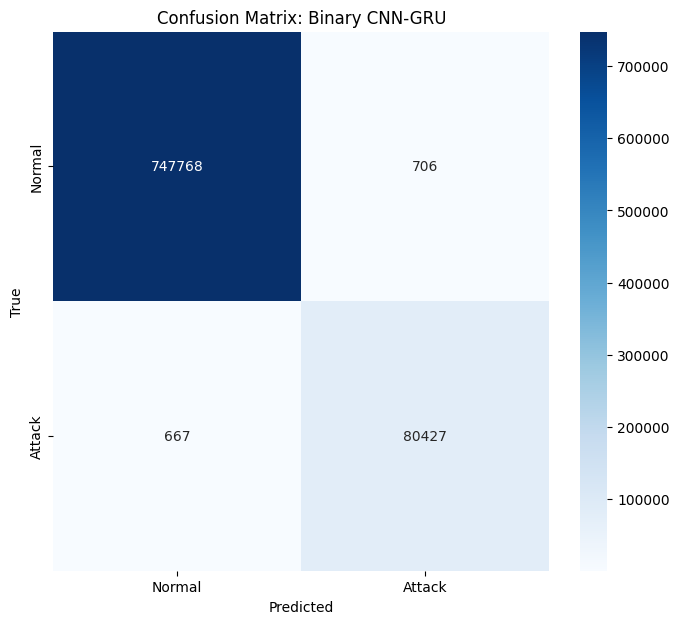

In [11]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_gru_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-GRU")


Model loaded from saved_models/binary_cnn1d.keras


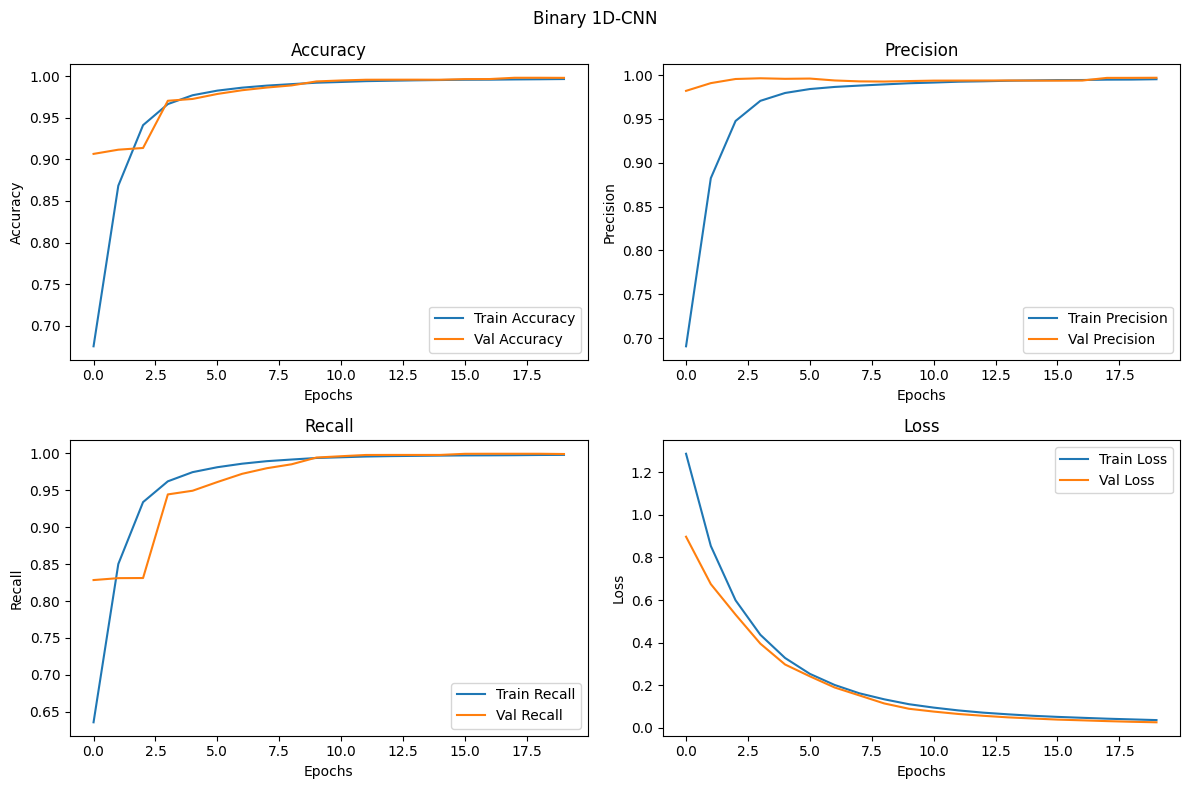

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 39)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 24)          │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 24)          │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 16)          │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 12)          │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 12)          │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,513 (21.54 KB)

 Trainable params: 1,797 (7.02 KB)

 Non-trainable params: 120 (480.00 B)

 Optimizer params: 3,596 (14.05 KB)

In [12]:
import binary_cnn1d
import data_utils

bin_cnn1d_model = binary_cnn1d.binary_CNN1D_model()

if not bin_cnn1d_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_cnn1d_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=20,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Binary 1D-CNN')
else:
    history = {'accuracy': [0.6756052374839783, 0.8683481216430664, 0.9410319924354553, 0.966303288936615, 0.9769217371940613, 0.982466459274292, 0.9860230088233948, 0.98848557472229, 0.990267276763916, 0.9919653534889221, 0.9928493499755859, 0.9938392043113708, 0.994346022605896, 0.9948341250419617, 0.9951976537704468, 0.9955116510391235, 0.9956071972846985, 0.9959024786949158, 0.9960986971855164, 0.9963700771331787], 'loss': [1.2863292694091797, 0.8537745475769043, 0.5986388921737671, 0.4369931221008301, 0.32793357968330383, 0.2535191774368286, 0.20141451060771942, 0.16224375367164612, 0.1341075599193573, 0.11108948290348053, 0.09511548280715942, 0.0818987786769867, 0.07140924781560898, 0.06358933448791504, 0.05671337619423866, 0.051536787301301956, 0.04726158082485199, 0.04309292882680893, 0.03975311666727066, 0.036497268825769424], 'precision': [0.6907044053077698, 0.8823795914649963, 0.9475935697555542, 0.9705383777618408, 0.9795224070549011, 0.9840027689933777, 0.9864014983177185, 0.9879310131072998, 0.9892802834510803, 0.9905923008918762, 0.9914035797119141, 0.9923737645149231, 0.9928304553031921, 0.993458092212677, 0.9938491582870483, 0.9942060708999634, 0.9942913055419922, 0.9947120547294617, 0.9948084354400635, 0.9951919913291931], 'recall': [0.636017382144928, 0.8500005006790161, 0.9337021708488464, 0.9618029594421387, 0.9742099046707153, 0.9808793067932129, 0.985633909702301, 0.9890539050102234, 0.9912759065628052, 0.9933647513389587, 0.9943204522132874, 0.995327353477478, 0.9958837032318115, 0.9962283968925476, 0.9965628981590271, 0.996832549571991, 0.9969383478164673, 0.997105598449707, 0.997402548789978, 0.9975595474243164], 'val_accuracy': [0.9065394401550293, 0.9115726947784424, 0.9136363863945007, 0.9702883958816528, 0.9724753499031067, 0.9784680604934692, 0.9829331040382385, 0.986181378364563, 0.9887328743934631, 0.9935141801834106, 0.9946558475494385, 0.9955295920372009, 0.9955939054489136, 0.9956153631210327, 0.9955510497093201, 0.9962692856788635, 0.9963657855987549, 0.9978934526443481, 0.9979095458984375, 0.9977969527244568], 'val_loss': [0.8969818949699402, 0.6747214794158936, 0.531442403793335, 0.39536020159721375, 0.2973610758781433, 0.24192996323108673, 0.18957529962062836, 0.15230363607406616, 0.11475236713886261, 0.08968057483434677, 0.07647109776735306, 0.06515474617481232, 0.056668128818273544, 0.04932112246751785, 0.04404512420296669, 0.03883887082338333, 0.03533818945288658, 0.03167106583714485, 0.028574012219905853, 0.02615336887538433], 'val_precision': [0.9819408655166626, 0.9907453656196594, 0.9954543113708496, 0.9962780475616455, 0.9956588745117188, 0.9959551692008972, 0.9937849640846252, 0.992742121219635, 0.9925558567047119, 0.9930912852287292, 0.9935922622680664, 0.9936561584472656, 0.9937202334403992, 0.9937837719917297, 0.9936459064483643, 0.9935812950134277, 0.9936982989311218, 0.9967272281646729, 0.9967592358589172, 0.9968647956848145], 'val_recall': [0.8283126354217529, 0.8309069275856018, 0.8310677409172058, 0.9441037774085999, 0.9490887522697449, 0.9608383178710938, 0.9719446897506714, 0.9795240163803101, 0.9848520755767822, 0.9939429759979248, 0.9957332611083984, 0.9974271059036255, 0.9974914193153381, 0.997469961643219, 0.9974806904792786, 0.9989922642707825, 0.9990673065185547, 0.9990673065185547, 0.9990673065185547, 0.9987350106239319]}
    plot_model_history(history, 'Binary 1D-CNN')
    
bin_cnn1d_model.summary()


25924/25924 ━━━━━━━━━━━━━━━━━━━━ 22s 838us/step
Accuracy: 99.673%
Precision: 96.848%
Recall: 99.906%
F1 : 0.98353
Kappa: 0.98172


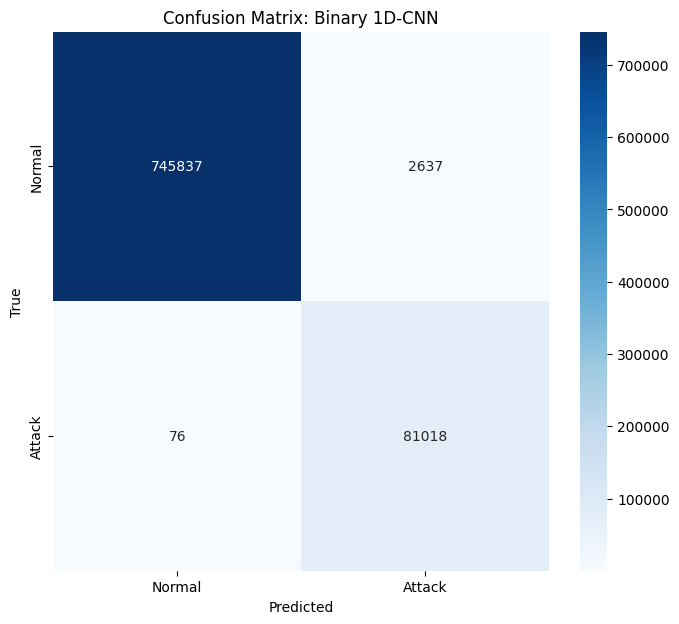

In [13]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn1d_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary 1D-CNN')


Model loaded from saved_models/binary_dnn.keras


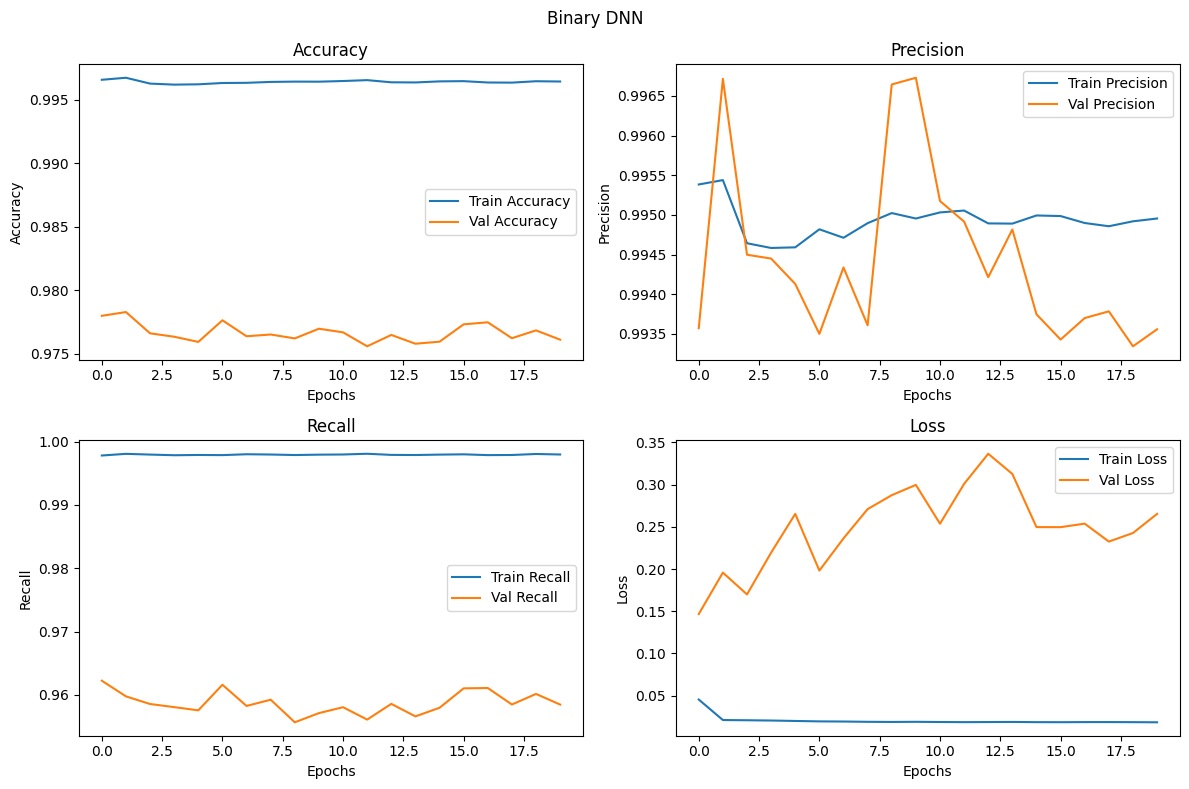

In [14]:
import binary_dnn
import data_utils

bin_dnn_model = binary_dnn.binary_DNN_model()

if not bin_dnn_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_dnn_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=20,
            callbacks = [binary_dnn.checkpoint_callback],
        )
    bin_dnn_model.summary()
    plot_model_history(history.history, 'Binary DNN')
else:
    history = {'accuracy': [0.9965814352035522, 0.9967400431632996, 0.9962809681892395, 0.9961997270584106, 0.9962242245674133, 0.9963274002075195, 0.9963415861129761, 0.9964125156402588, 0.9964370131492615, 0.996431827545166, 0.9964834451675415, 0.9965530633926392, 0.9963828325271606, 0.9963712096214294, 0.9964550733566284, 0.9964731335639954, 0.996367335319519, 0.9963570237159729, 0.9964666366577148, 0.9964447617530823], 'loss': [0.04539966955780983, 0.0211204681545496, 0.020860230550169945, 0.020531700924038887, 0.020026005804538727, 0.019525228068232536, 0.019351119175553322, 0.019010372459888458, 0.018851708620786667, 0.019014867022633553, 0.018782394006848335, 0.018619699403643608, 0.01873910427093506, 0.01886620558798313, 0.01861356571316719, 0.018561752513051033, 0.018678661435842514, 0.018701180815696716, 0.018609831109642982, 0.018442774191498756], 'precision': [0.9953842759132385, 0.9954392910003662, 0.9946429133415222, 0.9945835471153259, 0.994591474533081, 0.994818925857544, 0.994712233543396, 0.9948961734771729, 0.9950236678123474, 0.9949548840522766, 0.9950317740440369, 0.9950553774833679, 0.9948933124542236, 0.9948906302452087, 0.9949933290481567, 0.9949858784675598, 0.99489825963974, 0.9948574304580688, 0.9949195981025696, 0.9949550032615662], 'recall': [0.997789740562439, 0.9980527758598328, 0.9979367256164551, 0.9978335499763489, 0.9978748559951782, 0.9978516101837158, 0.9979883432388306, 0.9979444742202759, 0.9978645443916321, 0.9979238510131836, 0.9979496598243713, 0.998065710067749, 0.9978877305984497, 0.9978671073913574, 0.9979315996170044, 0.9979754090309143, 0.9978516101837158, 0.9978722333908081, 0.9980295896530151, 0.9979496598243713], 'val_accuracy': [0.9780026078224182, 0.978299081325531, 0.9766246676445007, 0.9763556718826294, 0.9759494662284851, 0.9776512980461121, 0.9763941168785095, 0.9765313863754272, 0.9762239456176758, 0.9769870042800903, 0.976701557636261, 0.9756035804748535, 0.9764984250068665, 0.975806713104248, 0.9759659171104431, 0.9773328900337219, 0.977492094039917, 0.9762403964996338, 0.9768552780151367, 0.9761251211166382], 'val_loss': [0.1466568261384964, 0.19578522443771362, 0.16991949081420898, 0.21944405138492584, 0.2653358578681946, 0.19818998873233795, 0.23630042374134064, 0.2709701955318451, 0.2874850630760193, 0.2996620535850525, 0.25369521975517273, 0.30087709426879883, 0.33655574917793274, 0.3126213550567627, 0.2496926337480545, 0.24959908425807953, 0.253773957490921, 0.23254331946372986, 0.24266037344932556, 0.26534149050712585], 'val_precision': [0.9935718774795532, 0.9967161417007446, 0.994498074054718, 0.9944499135017395, 0.9941295981407166, 0.9934999942779541, 0.9943376779556274, 0.9936084151268005, 0.9966450929641724, 0.9967299103736877, 0.9951757192611694, 0.9949157238006592, 0.9942150712013245, 0.9948161840438843, 0.9937470555305481, 0.9934285283088684, 0.9936995506286621, 0.9937843680381775, 0.9933435320854187, 0.9935581088066101], 'val_recall': [0.9622305631637573, 0.9597601890563965, 0.9585524797439575, 0.9580584168434143, 0.9575533270835876, 0.9615938067436218, 0.958245038986206, 0.9592331647872925, 0.955664873123169, 0.9571141600608826, 0.9580473899841309, 0.9560930728912354, 0.9585744142532349, 0.9565981030464172, 0.9579595923423767, 0.9610228538513184, 0.9610777497291565, 0.9584755897521973, 0.9601444602012634, 0.9584646224975586]}	
    plot_model_history(history, 'Binary DNN')

25924/25924 ━━━━━━━━━━━━━━━━━━━━ 15s 568us/step
Accuracy: 99.169%
Precision: 92.352%
Recall: 99.756%
F1 : 0.95911
Kappa: 0.95449


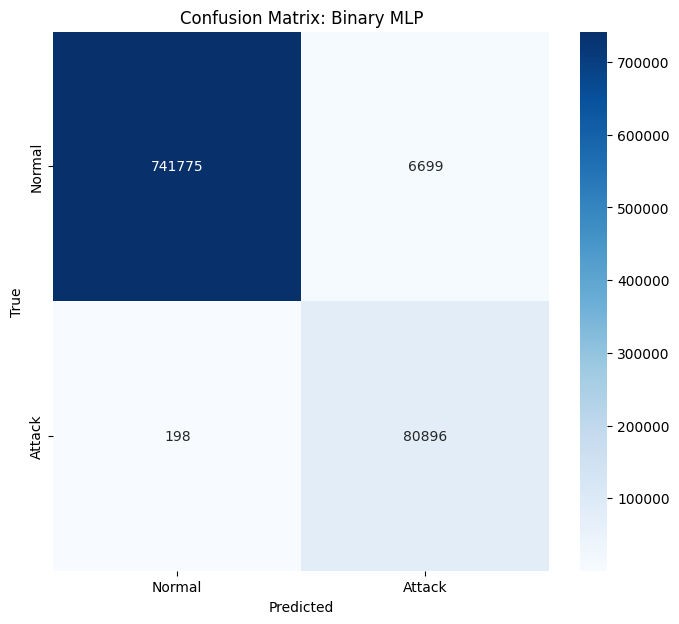

In [15]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_dnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary MLP')

### Results:

* Binary CNN-LSTM
    * Accuracy: 98.792%
    * Precision: 91.295%
    * Recall: 98.053%
    * F1 : 0.9455
    * Kappa: 0.9388
* Binary CNN-GRU
    * Accuracy: 98.952%
    * Precision: 91.447%
    * Recall: 99.505%
    * F1 : 0.9531
    * Kappa: 0.9472
* Binary Time Domain CNN
    * Accuracy: 95.407%
    * Precision: 89.891%
    * Recall: 64.270%
    * F1 : 0.7495
    * Kappa: 0.7250
* Binary 1D-CNN
    * Accuracy: 98.795%
    * Precision: 89.953%
    * Recall: 99.884%
    * F1 : 0.9466
    * Kappa: 0.9398
* Binary DNN
    * Accuracy: 98.393%
    * Precision: 89.714%
    * Recall: 95.974%
    * F1 : 0.9274
    * Kappa: 0.9184


In [16]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

bin_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_arithmetic_mean_aggregate1.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     16,593 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 1)   │      1,917 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, None, 1)   │          0 │ bin_CNN_LSTM[0][… │
│                     │                   │            │ binary_CNN_GRU[0… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,487 (103.46 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 26,487 (103.46 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 49s 133ms/step
Accuracy: 99.806%
Precision: 98.677%
Recall: 99.351%
F1 : 0.99013
Kappa: 0.98906


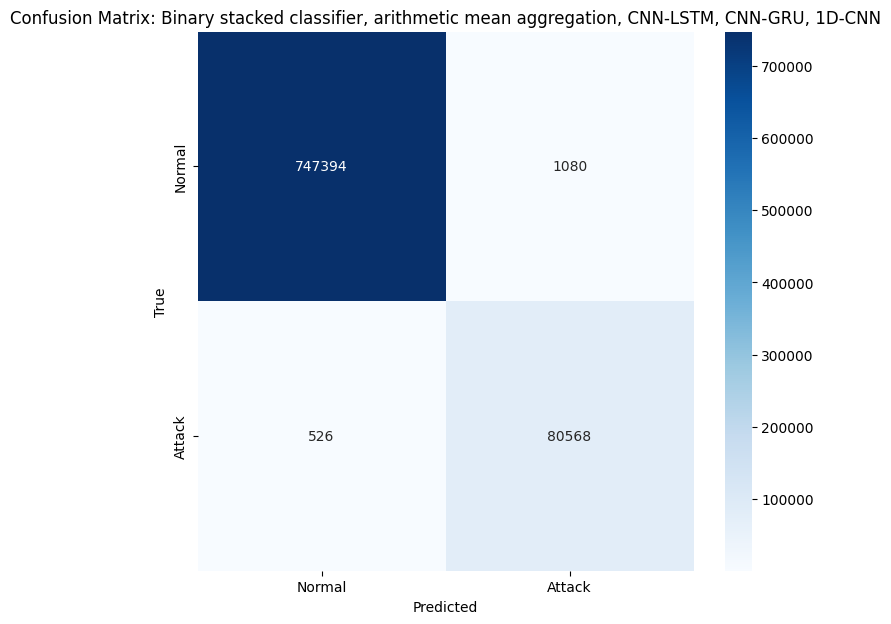

In [17]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_arithmentic_mean_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean aggregation, CNN-LSTM, CNN-GRU, 1D-CNN')

In [18]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

bin_f1_weights = [
    bin_cnn_lstm_metrics[3],
    bin_cnn_gru_metrics[3],
    bin_cnn1d_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print('F1 calculated_weights')
print(bin_f1_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate1 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate1.summary()

F1 calculated_weights
[0.35554063 0.34675145 0.29770792]


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     16,593 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 1)   │      1,917 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[1][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[1… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 3)   │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, None, 3)   │          0 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,487 (103.46 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 26,487 (103.46 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 54s 148ms/step
Accuracy: 99.819%
Precision: 98.814%
Recall: 99.345%
F1 : 0.99079
Kappa: 0.98979


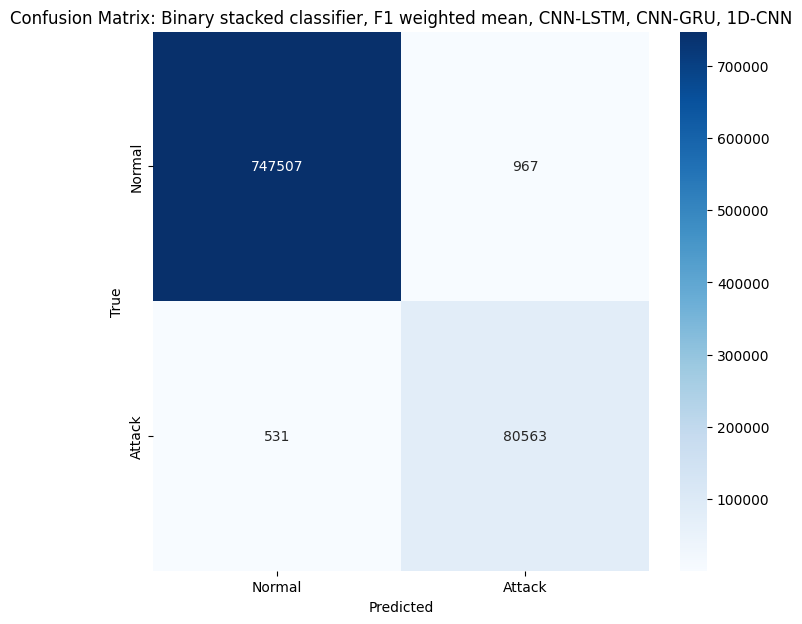

In [19]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_f1_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 weighted mean, CNN-LSTM, CNN-GRU, 1D-CNN')

In [20]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn_gru_metrics[4],
    bin_cnn1d_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print('Kappa score calculated weights')
print(bin_kappa_weights.numpy())

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate1.summary()

Kappa score calculated weights
[0.35291678 0.34518245 0.30190074]


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     16,593 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, None, 1)   │      1,917 │ input_layer_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[2][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[2… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, None, 3)   │          0 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,487 (103.46 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 26,487 (103.46 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 59s 172ms/step
Accuracy: 99.819%
Precision: 98.810%
Recall: 99.346%
F1 : 0.99078
Kappa: 0.98977


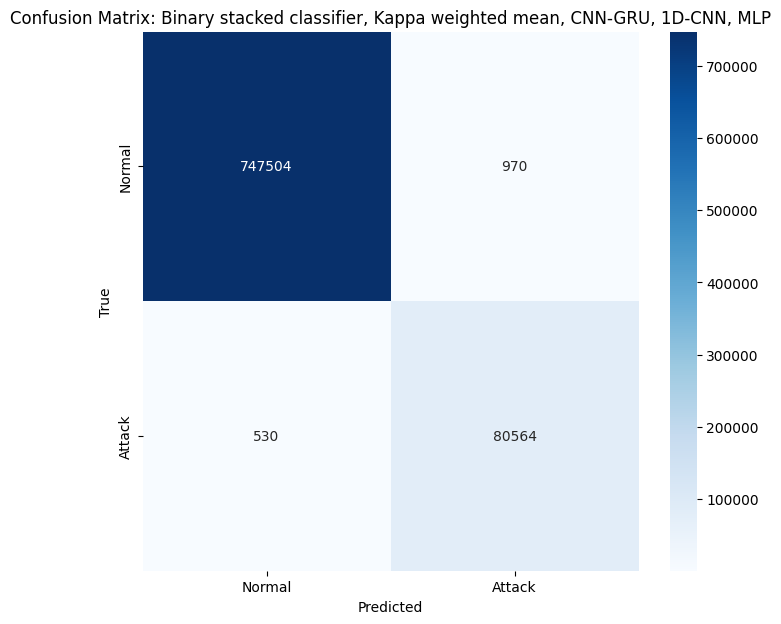

In [21]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
kappa_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Kappa weighted mean, CNN-GRU, 1D-CNN, MLP')

In [22]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]


# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)


bin_stacked_log_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_stacked_log_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor1.summary()

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     16,593 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, None, 1)   │      1,917 │ input_layer_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[3][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[3… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, None, 1)   │          4 │ concatenate_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,491 (103.48 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 26,487 (103.46 KB)

Epoch 1/5
    299/Unknown 37s 69ms/step - accuracy: 0.9991 - loss: 0.0085 - precision: 0.9919 - recall: 0.9993

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 68s 173ms/step - accuracy: 0.9991 - loss: 0.0085 - precision: 0.9919 - recall: 0.9993 - val_accuracy: 0.9973 - val_loss: 0.0057 - val_precision: 0.9807 - val_recall: 0.9918
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 59s 170ms/step - accuracy: 0.9992 - loss: 0.0049 - precision: 0.9925 - recall: 0.9994 - val_accuracy: 0.9974 - val_loss: 0.0040 - val_precision: 0.9819 - val_recall: 0.9916
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - accuracy: 0.9994 - loss: 0.0032 - precision: 0.9943 - recall: 0.9994 - val_accuracy: 0.9975 - val_loss: 0.0031 - val_precision: 0.9834 - val_recall: 0.9915
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 189ms/step - accuracy: 0.9995 - loss: 0.0024 - precision: 0.9949 - recall: 0.9996 - val_accuracy: 0.9976 - val_loss: 0.0026 - val_precision: 0.9844 - val_recall: 0.9914
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 190ms/step - accuracy: 0.9995 - loss: 0.0018 - precision: 0.9957 - recall: 0.9995 - val_accuracy: 0.9977 - val_loss: 0.

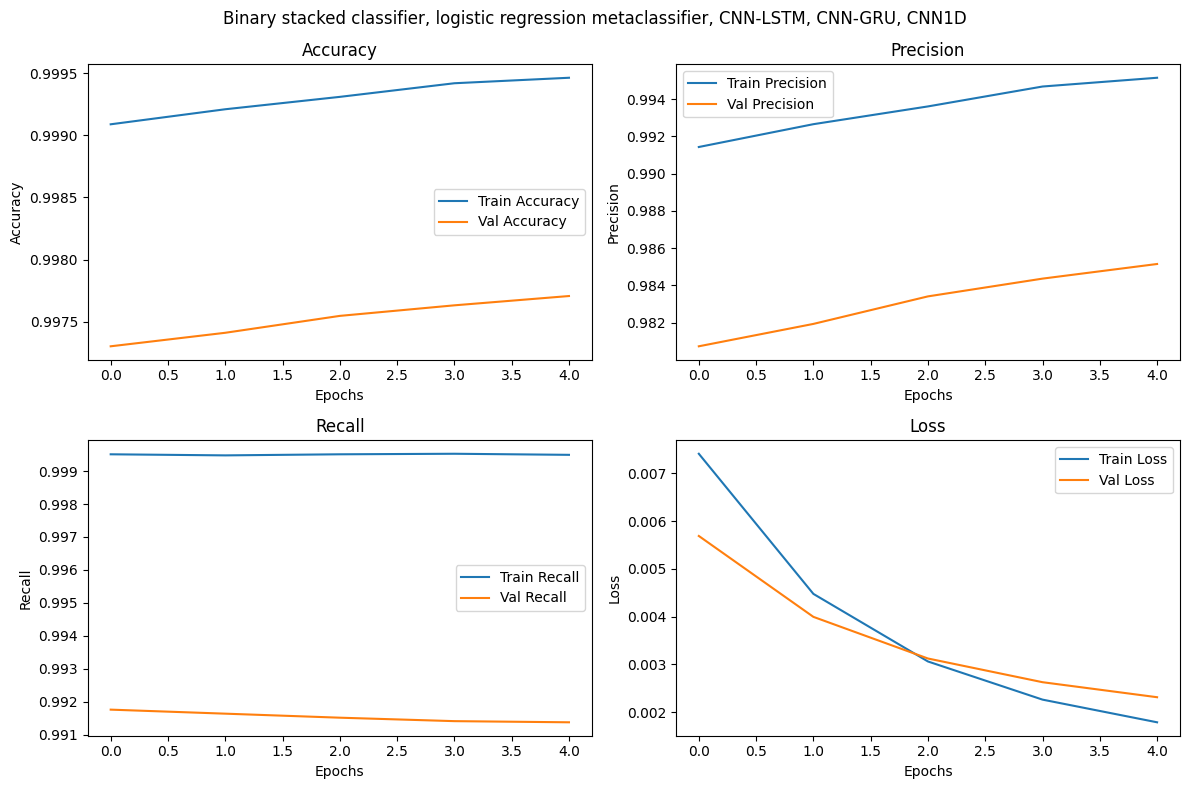

In [23]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files[:15])
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)
history = bin_stacked_log_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
plot_model_history(history.history, 'Binary stacked classifier, logistic regression metaclassifier, CNN-LSTM, CNN-GRU, CNN1D')

203/203 ━━━━━━━━━━━━━━━━━━━━ 57s 165ms/step
Accuracy: 99.823%
Precision: 98.789%
Recall: 99.409%
F1 : 0.99098
Kappa: 0.99000


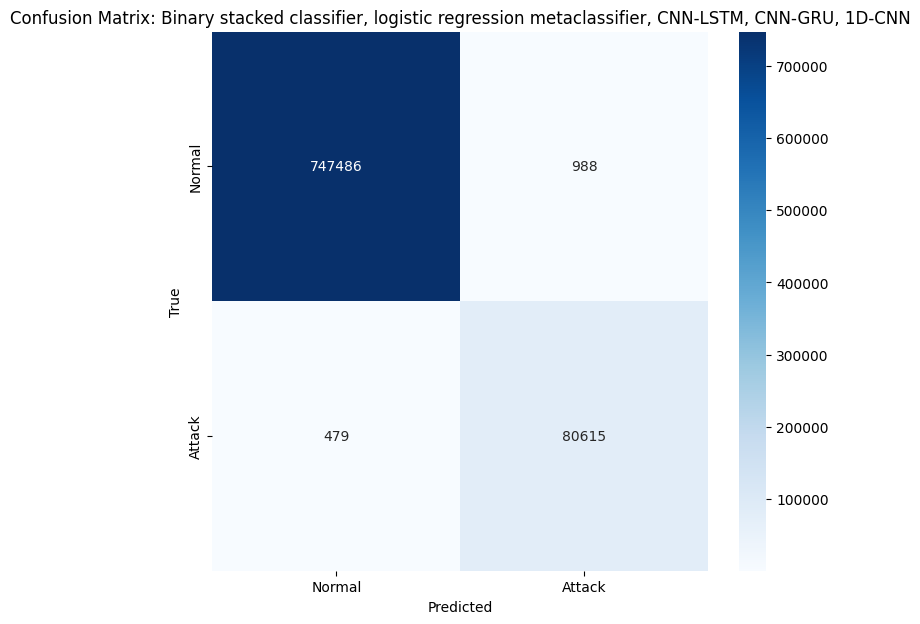

In [24]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_log_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression metaclassifier, CNN-LSTM, CNN-GRU, 1D-CNN')

In [25]:
output_layer = bin_stacked_log_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[1.8844597]
 [1.835018 ]
 [1.2330554]]
Logistic regressor bias:  [-2.3158128]


In [26]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn_gru_metrics[4],
    bin_cnn1d_metrics[4],
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-0.5)))(y)

bin_kappa_weighted_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_kappa_weighted_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor1.summary()

tf.Tensor([0.35291678 0.34518245 0.30190074], shape=(3,), dtype=float32)


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     16,593 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, None, 1)   │      1,917 │ input_layer_4[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[5][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[5… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, None, 1)   │          4 │ lambda_4[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,491 (103.48 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 26,487 (103.46 KB)

Epoch 1/5
    298/Unknown 40s 76ms/step - accuracy: 0.9995 - loss: 0.0646 - precision: 0.9955 - recall: 0.9995

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 76s 198ms/step - accuracy: 0.9995 - loss: 0.0645 - precision: 0.9955 - recall: 0.9995 - val_accuracy: 0.9981 - val_loss: 0.0444 - val_precision: 0.9909 - val_recall: 0.9891
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.9996 - loss: 0.0412 - precision: 0.9984 - recall: 0.9978 - val_accuracy: 0.9981 - val_loss: 0.0303 - val_precision: 0.9937 - val_recall: 0.9870
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 190ms/step - accuracy: 0.9995 - loss: 0.0288 - precision: 0.9986 - recall: 0.9963 - val_accuracy: 0.9981 - val_loss: 0.0220 - val_precision: 0.9939 - val_recall: 0.9866
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 187ms/step - accuracy: 0.9995 - loss: 0.0213 - precision: 0.9988 - recall: 0.9959 - val_accuracy: 0.9981 - val_loss: 0.0168 - val_precision: 0.9936 - val_recall: 0.9872
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 69s 194ms/step - accuracy: 0.9995 - loss: 0.0164 - precision: 0.9985 - recall: 0.9964 - val_accuracy: 0.9981 - val_loss: 0.

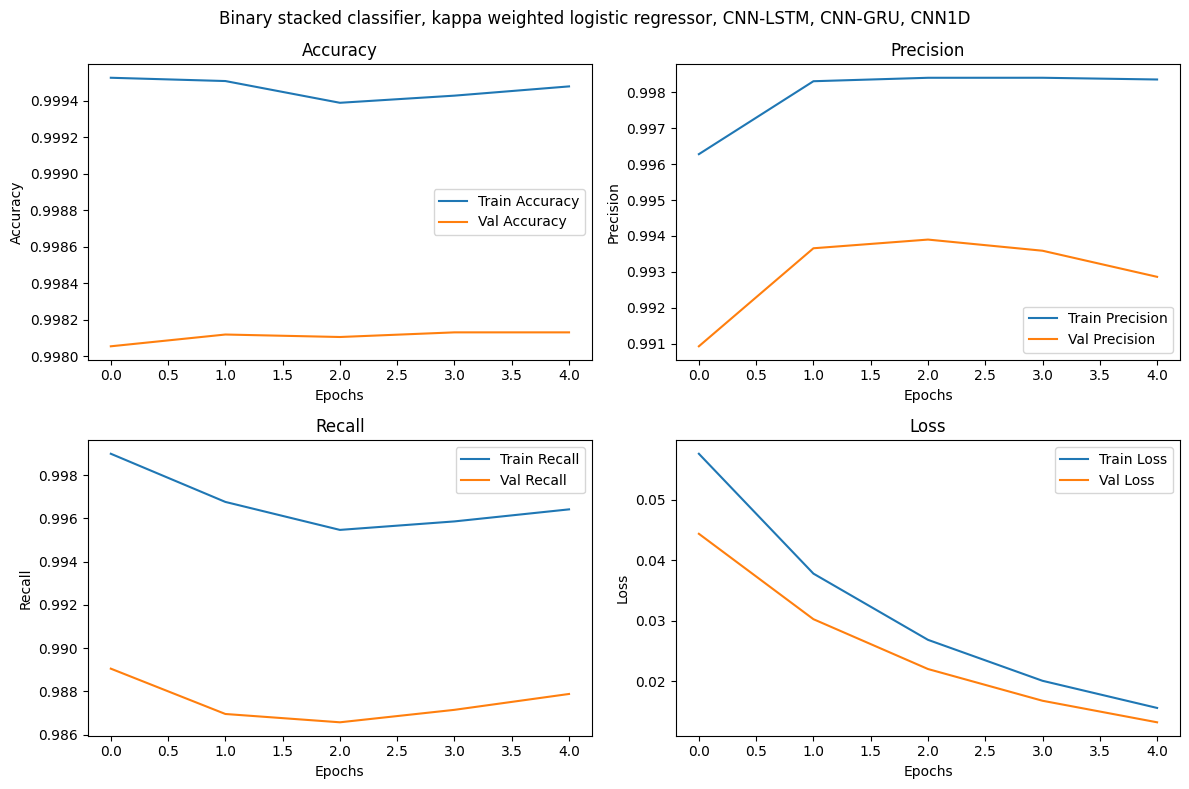

In [27]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files[:15])
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_kappa_weighted_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Binary stacked classifier, kappa weighted logistic regressor, CNN-LSTM, CNN-GRU, CNN1D')

203/203 ━━━━━━━━━━━━━━━━━━━━ 56s 154ms/step
Accuracy: 99.831%
Precision: 99.273%
Recall: 98.997%
F1 : 0.99135
Kappa: 0.99041


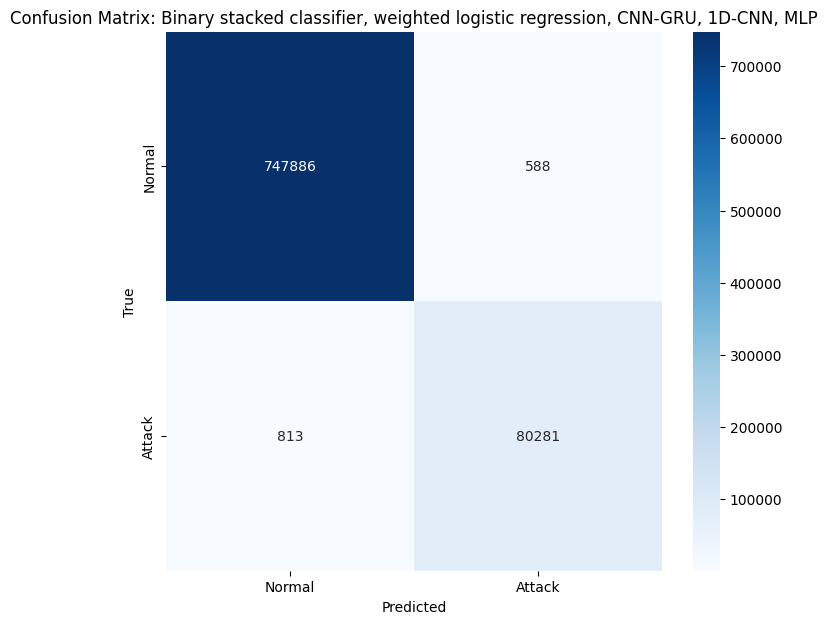

In [28]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_kappa_weighted_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, weighted logistic regression, CNN-GRU, 1D-CNN, MLP')

In [29]:
output_layer = bin_kappa_weighted_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[2.3532944]
 [2.3647165]
 [2.382187 ]]
Logistic regressor bias:  [-1.3659304]


In [30]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    td_bin_cnn1d_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)


bin_stacked_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_stacked_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier1.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     16,593 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      7,977 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, None, 1)   │      1,917 │ input_layer_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[6][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[6… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, None, 4)   │         16 │ concatenate_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,528 (103.62 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 26,487 (103.46 KB)

Epoch 1/5
    298/Unknown 39s 75ms/step - accuracy: 0.9974 - loss: 0.0046 - precision: 0.9992 - recall: 0.9733

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 72s 185ms/step - accuracy: 0.9974 - loss: 0.0046 - precision: 0.9992 - recall: 0.9733 - val_accuracy: 0.9981 - val_loss: 0.0048 - val_precision: 0.9934 - val_recall: 0.9869
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 62s 179ms/step - accuracy: 0.9995 - loss: 0.0016 - precision: 0.9982 - recall: 0.9962 - val_accuracy: 0.9981 - val_loss: 0.0045 - val_precision: 0.9932 - val_recall: 0.9872
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 189ms/step - accuracy: 0.9995 - loss: 0.0013 - precision: 0.9983 - recall: 0.9970 - val_accuracy: 0.9981 - val_loss: 0.0044 - val_precision: 0.9929 - val_recall: 0.9878
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.9996 - loss: 0.0010 - precision: 0.9984 - recall: 0.9971 - val_accuracy: 0.9981 - val_loss: 0.0043 - val_precision: 0.9923 - val_recall: 0.9883
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 63s 180ms/step - accuracy: 0.9996 - loss: 8.8693e-04 - precision: 0.9982 - recall: 0.9972 - val_accuracy: 0.9981 - val_loss

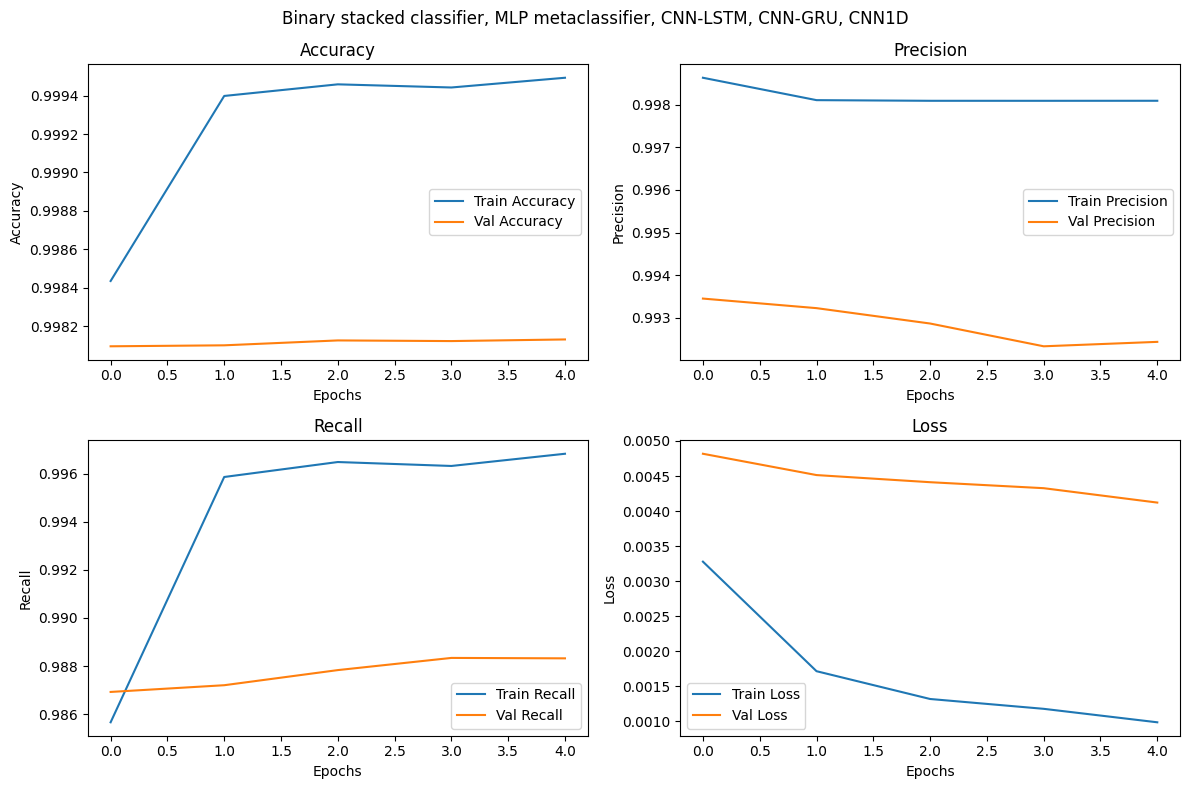

In [31]:
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files[:15])
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_stacked_dnn_classifier1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Binary stacked classifier, MLP metaclassifier, CNN-LSTM, CNN-GRU, CNN1D')

203/203 ━━━━━━━━━━━━━━━━━━━━ 62s 171ms/step
Accuracy: 99.830%
Precision: 99.242%
Recall: 99.020%
F1 : 0.99131
Kappa: 0.99037


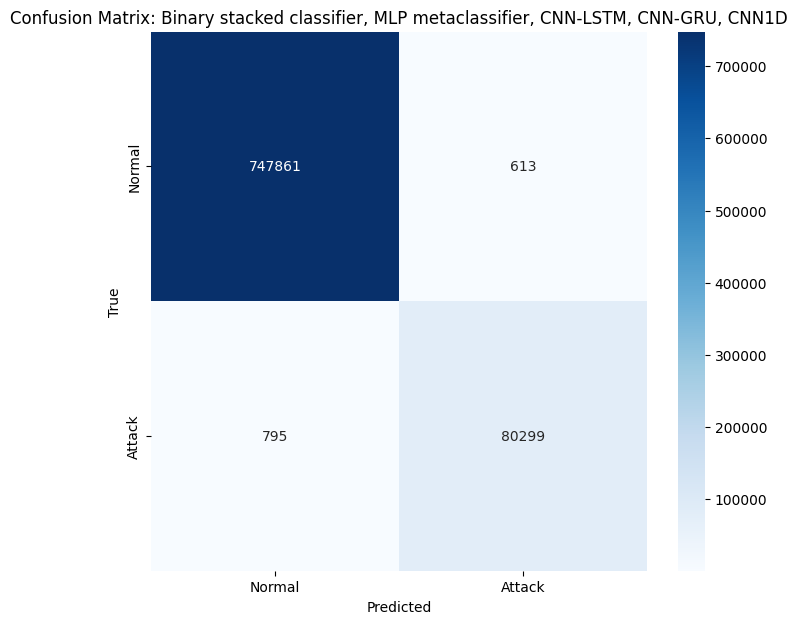

In [32]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_dnn_classifier_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP metaclassifier, CNN-LSTM, CNN-GRU, CNN1D')

### Top 3 Binary Models:

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| CNN-LSTM                   | 98.792%  | 91.295%   | 98.053% | 0.9455   | 0.9388  |
| CNN-GRU                    | 98.952%  | 91.447%   | 99.505% | 0.9531   | 0.9472  |
| 1D-CNN                     | 98.795%  | 89.953%   | 99.884% | 0.9466   | 0.9398  |
| Arithmetic mean            | 98.792%  | 90.027%   | 99.755% | 0.9464   | 0.9396  |
| Improvement from best      | -0.160%  | -1.420%   |  0.250% | -0.0067  | -0.0076 |
| F1 weighted mean           | 98.793%  | 90.032%   | 99.754% | 0.9464   | 0.9397  |
| Improvement from best      | -0.159%  | -1.415%   |  0.249% | -0.0067  | -0.0075 |
| Kappa weighted mean        | 98.793%  | 90.032%   | 99.754% | 0.9464   | 0.9397  |
| Improvement from best      | -0.159%  | -1.415%   |  0.249% | -0.0067  | -0.0075 |
| Logistic regression        | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Improvement from best      | -0.174%  | -1.470%   |  0.279% | -0.0068  | -0.0073 |
| Kappa weighted log. reg.   | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Improvement from best      | -0.174%  | -1.470%   |  0.279% | -0.0068  | -0.0073 |
| Stacked MLP                | 98.889%  | 87.903%   | 99.839% | 0.9349   | 0.9289  |
| Improvement from best      | -0.063%  | -3.550%   |  0.334% | -0.0182  | -0.0179 |




In [33]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall'],
)

bin_arithmetic_mean_aggregate2.summary()

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, None, 1)   │      1,917 │ input_layer_6[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, None, 1)   │      2,017 │ input_layer_6[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      7,521 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_1 (Average) │ (None, None, 1)   │          0 │ time_distributed… │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,455 (44.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,455 (44.75 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 57s 140ms/step
Accuracy: 99.145%
Precision: 92.028%
Recall: 99.914%
F1 : 0.95809
Kappa: 0.95334


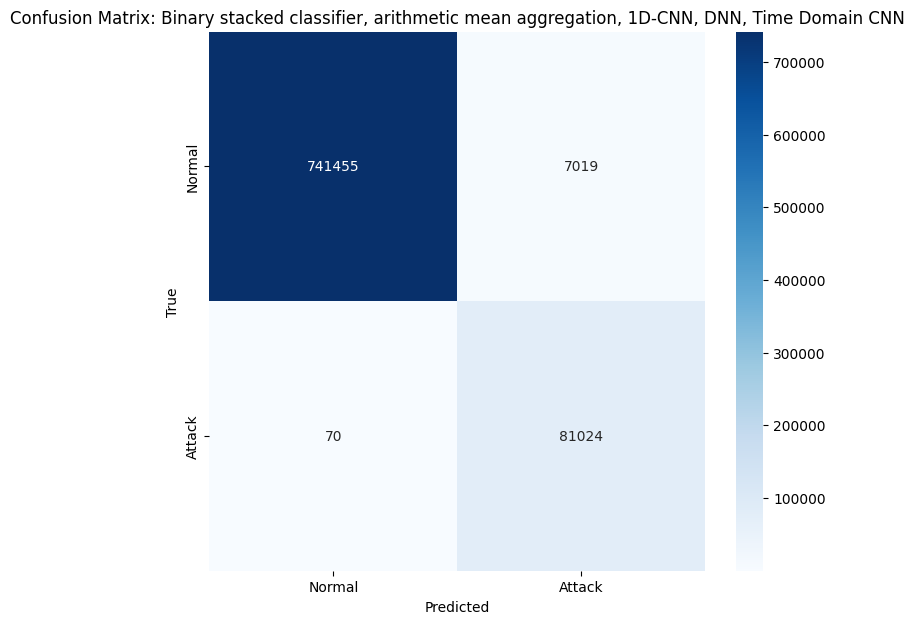

(0.9914545884122821,
 0.9202775916313619,
 0.9991368042025304,
 0.9580872310612107,
 0.9533384506049176)

In [34]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean aggregation, 1D-CNN, DNN, Time Domain CNN')

In [35]:
import math
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_f1_weights = [
    bin_cnn1d_metrics[3],
    bin_dnn_metrics[3],
    bin_td_cnn_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print(bin_f1_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate2 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate2.summary()

tf.Tensor([0.35561952 0.27435806 0.37002242], shape=(3,), dtype=float32)


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None, 1)   │      1,917 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, None, 1)   │      2,017 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      7,521 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, None, 3)   │          0 │ lambda_5[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,455 (44.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,455 (44.75 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 63s 173ms/step
Accuracy: 99.644%
Precision: 96.592%
Recall: 99.887%
F1 : 0.98212
Kappa: 0.98014


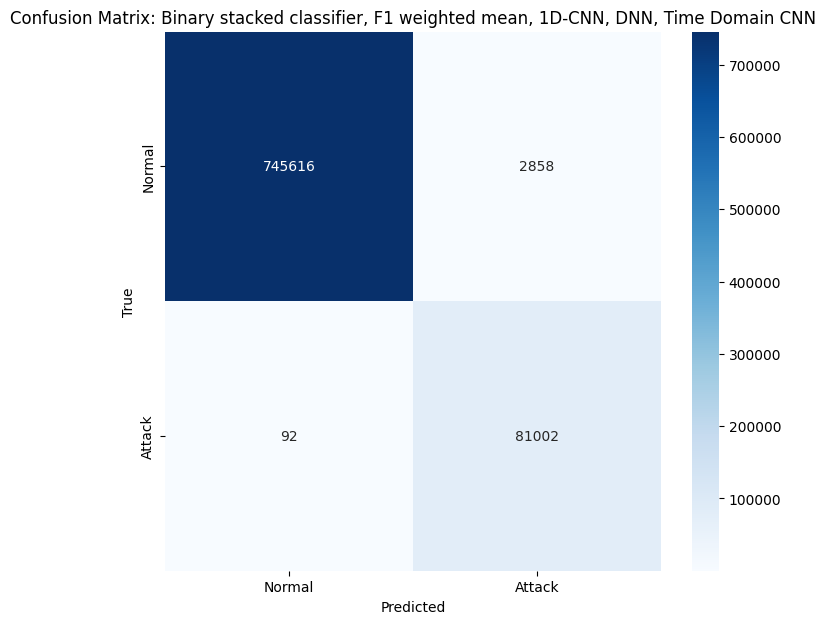

(0.9964439322635396,
 0.9659193894586215,
 0.9988655140947542,
 0.9821162263418892,
 0.9801425183282804)

In [36]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 weighted mean, 1D-CNN, DNN, Time Domain CNN')

In [37]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_kappa_weights = [
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
    bin_td_cnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

bin_kappa_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate2.summary()

tf.Tensor([0.35235947 0.28274685 0.36489367], shape=(3,), dtype=float32)


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None, 1)   │      1,917 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, None, 1)   │      2,017 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      7,521 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, None, 3)   │          0 │ lambda_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,455 (44.75 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,455 (44.75 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 60s 166ms/step
Accuracy: 99.621%
Precision: 96.372%
Recall: 99.885%
F1 : 0.98097
Kappa: 0.97887


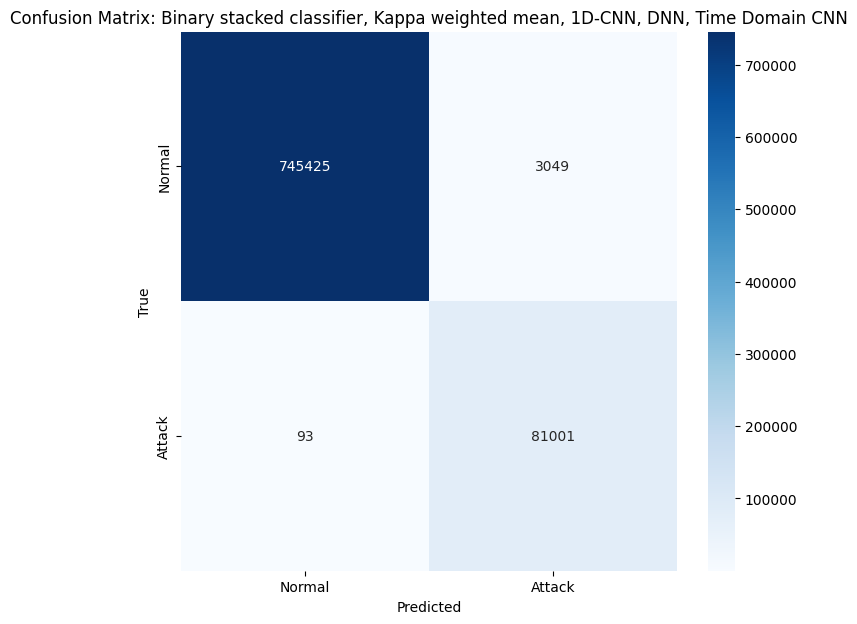

(0.9962124864989971,
 0.9637239738251041,
 0.9988531827262189,
 0.9809741801094802,
 0.978871838137371)

In [38]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Kappa weighted mean, 1D-CNN, DNN, Time Domain CNN')

In [39]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate
from keras.initializers import RandomNormal
input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)


bin_stacked_log_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_stacked_log_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor2.summary()

Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None, 1)   │      1,917 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, None, 1)   │      2,017 │ input_layer_8[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      7,521 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[3][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, None, 1)   │          4 │ concatenate_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,459 (44.76 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 11,455 (44.75 KB)

Epoch 1/5
    296/Unknown 38s 66ms/step - accuracy: 0.9962 - loss: 0.0095 - precision: 0.9615 - recall: 0.9997

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.9962 - loss: 0.0095 - precision: 0.9615 - recall: 0.9997 - val_accuracy: 0.9762 - val_loss: 0.0110 - val_precision: 0.8041 - val_recall: 0.9987
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 63s 175ms/step - accuracy: 0.9965 - loss: 0.0062 - precision: 0.9647 - recall: 0.9998 - val_accuracy: 0.9761 - val_loss: 0.0097 - val_precision: 0.8035 - val_recall: 0.9987
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.9965 - loss: 0.0047 - precision: 0.9652 - recall: 0.9998 - val_accuracy: 0.9765 - val_loss: 0.0087 - val_precision: 0.8064 - val_recall: 0.9985
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.9970 - loss: 0.0038 - precision: 0.9702 - recall: 0.9997 - val_accuracy: 0.9766 - val_loss: 0.0083 - val_precision: 0.8066 - val_recall: 0.9985
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 61s 174ms/step - accuracy: 0.9971 - loss: 0.0032 - precision: 0.9706 - recall: 0.9997 - val_accuracy: 0.9766 - val_loss: 0.

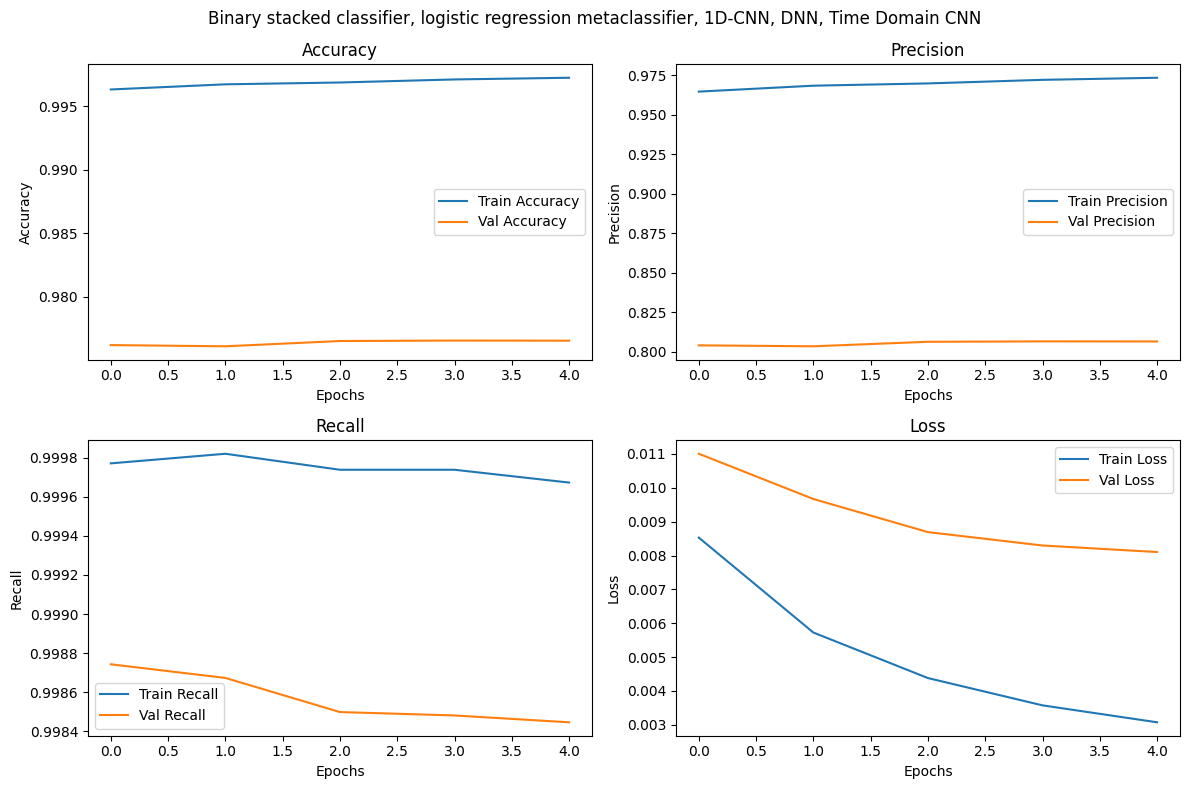

In [40]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files[:15])
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

#tf.config.run_functions_eagerly(True)
history = bin_stacked_log_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
#tf.config.run_functions_eagerly(False)
plot_model_history(history.history, 'Binary stacked classifier, logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [41]:
output_layer = bin_stacked_log_regressor2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[1.33056  ]
 [1.7952257]
 [1.3395932]]
Logistic regressor bias:  [-2.3291092]


203/203 ━━━━━━━━━━━━━━━━━━━━ 97s 325ms/step
Accuracy: 99.141%
Precision: 91.984%
Recall: 99.926%
F1 : 0.95791
Kappa: 0.95313


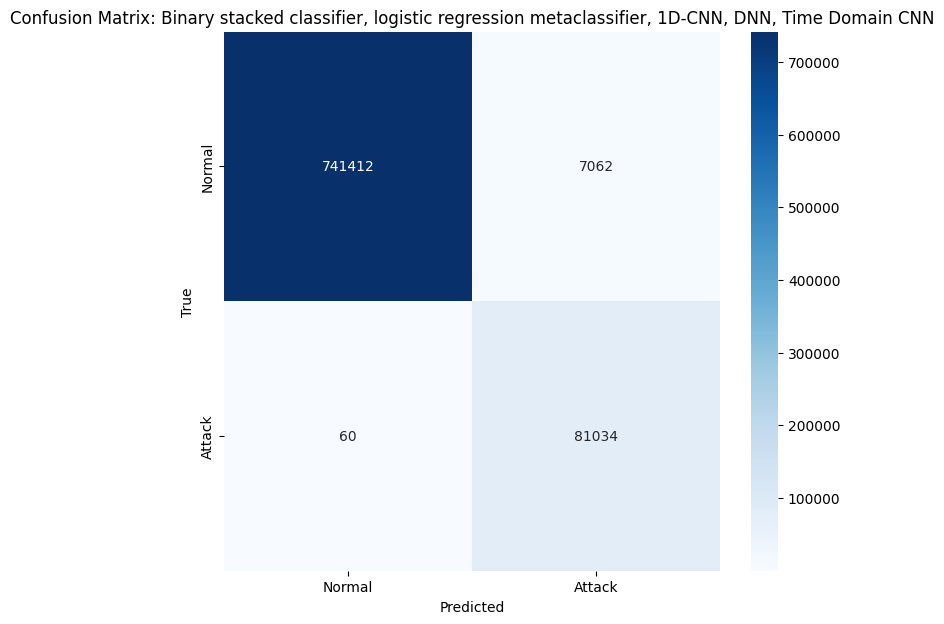

(0.9914148086715013,
 0.919837450054486,
 0.9992601178878832,
 0.9579053135528105,
 0.9531343894733236)

In [42]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [43]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_kappa_weights = [
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
    bin_td_cnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = [w / sum_bin_kappa_weights for w in bin_kappa_weights]

bin_kappa_weights = tf.constant(bin_kappa_weights, dtype=tf.float32)

print(bin_kappa_weights)

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-0.5)))(y)

bin_kappa_weighted_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_kappa_weighted_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor2.summary()

tf.Tensor([0.35235947 0.28274685 0.36489367], shape=(3,), dtype=float32)


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, None, 1)   │      1,917 │ input_layer_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, None, 1)   │      2,017 │ input_layer_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      7,521 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[4][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, None, 1)   │          4 │ lambda_9[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,459 (44.76 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 11,455 (44.75 KB)

Epoch 1/5
    296/Unknown 40s 73ms/step - accuracy: 0.9969 - loss: 0.0648 - precision: 0.9698 - recall: 0.9980

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 73s 182ms/step - accuracy: 0.9969 - loss: 0.0647 - precision: 0.9699 - recall: 0.9980 - val_accuracy: 0.9969 - val_loss: 0.0451 - val_precision: 0.9718 - val_recall: 0.9970
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 64s 180ms/step - accuracy: 0.9979 - loss: 0.0417 - precision: 0.9845 - recall: 0.9937 - val_accuracy: 0.9977 - val_loss: 0.0313 - val_precision: 0.9796 - val_recall: 0.9968
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 72s 209ms/step - accuracy: 0.9978 - loss: 0.0296 - precision: 0.9880 - recall: 0.9894 - val_accuracy: 0.9977 - val_loss: 0.0232 - val_precision: 0.9801 - val_recall: 0.9968
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 75s 219ms/step - accuracy: 0.9978 - loss: 0.0222 - precision: 0.9875 - recall: 0.9898 - val_accuracy: 0.9976 - val_loss: 0.0182 - val_precision: 0.9794 - val_recall: 0.9968
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 60s 165ms/step - accuracy: 0.9978 - loss: 0.0174 - precision: 0.9871 - recall: 0.9902 - val_accuracy: 0.9975 - val_loss: 0.

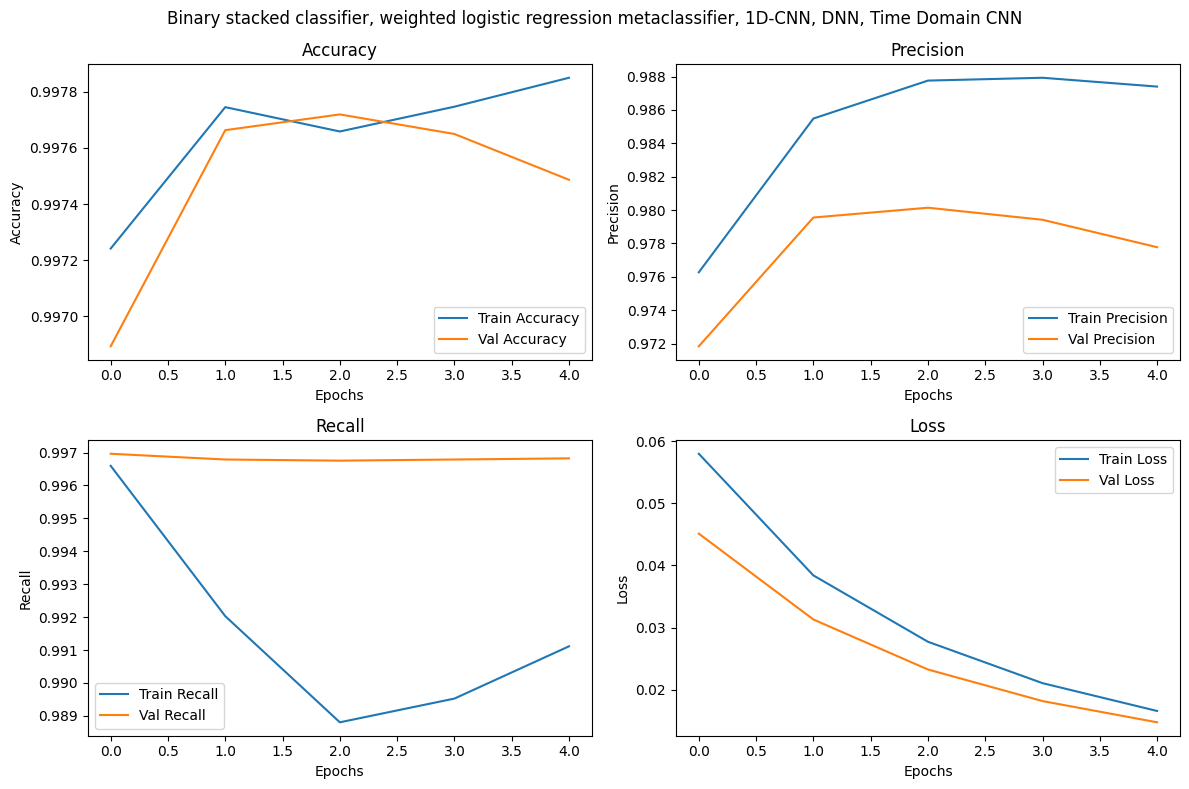

In [44]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files[:15])
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_kappa_weighted_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Binary stacked classifier, weighted logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [45]:
output_layer = bin_kappa_weighted_regressor2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[2.418348 ]
 [2.2963314]
 [2.370881 ]]
Logistic regressor bias:  [-1.383323]


203/203 ━━━━━━━━━━━━━━━━━━━━ 135s 510ms/step
Accuracy: 99.786%
Precision: 98.020%
Recall: 99.830%
F1 : 0.98917
Kappa: 0.98798


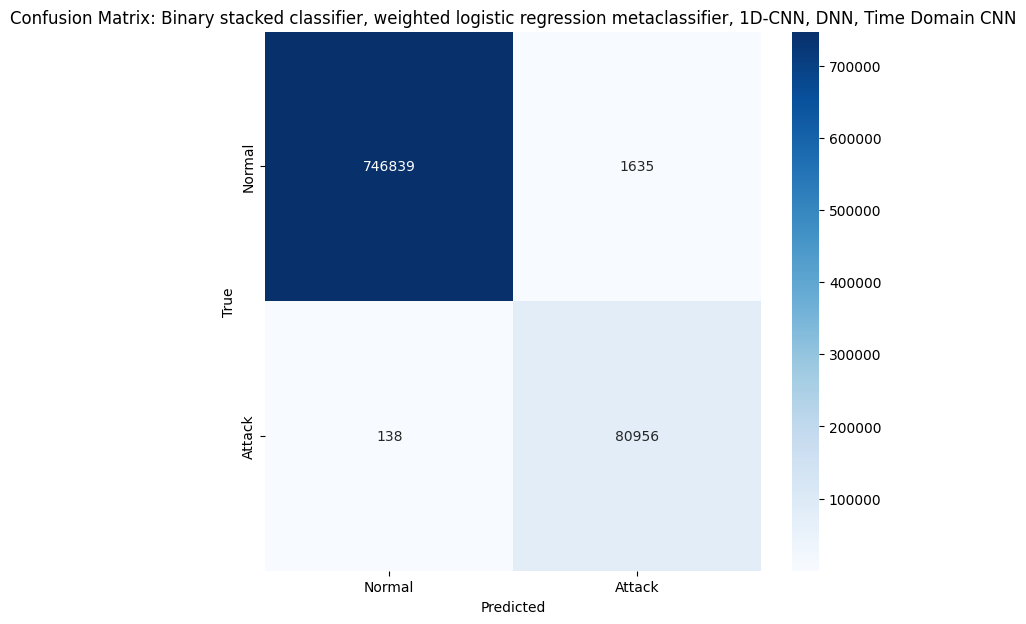

(0.9978627430180528,
 0.9802036541511787,
 0.9982982711421313,
 0.989168219445887,
 0.9879827339490155)

In [46]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, weighted logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [47]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]

# disabling training of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)


bin_stacked_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

bin_stacked_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier2.summary()

Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, None, 1)   │      1,917 │ input_layer_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, None, 1)   │      2,017 │ input_layer_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      7,521 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[5][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, None, 4)   │         16 │ concatenate_11[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,496 (44.91 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 11,455 (44.75 KB)

Epoch 1/5
    299/Unknown 45s 80ms/step - accuracy: 0.9960 - loss: 0.0068 - precision: 0.9944 - recall: 0.9630

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 115s 315ms/step - accuracy: 0.9960 - loss: 0.0068 - precision: 0.9944 - recall: 0.9631 - val_accuracy: 0.9984 - val_loss: 0.0065 - val_precision: 0.9874 - val_recall: 0.9967
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 181ms/step - accuracy: 0.9983 - loss: 0.0038 - precision: 0.9929 - recall: 0.9892 - val_accuracy: 0.9985 - val_loss: 0.0049 - val_precision: 0.9878 - val_recall: 0.9966
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 0.9983 - loss: 0.0032 - precision: 0.9927 - recall: 0.9894 - val_accuracy: 0.9984 - val_loss: 0.0044 - val_precision: 0.9874 - val_recall: 0.9966
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 57s 162ms/step - accuracy: 0.9984 - loss: 0.0026 - precision: 0.9924 - recall: 0.9912 - val_accuracy: 0.9984 - val_loss: 0.0036 - val_precision: 0.9877 - val_recall: 0.9964
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 56s 161ms/step - accuracy: 0.9986 - loss: 0.0021 - precision: 0.9924 - recall: 0.9927 - val_accuracy: 0.9984 - val_loss: 0

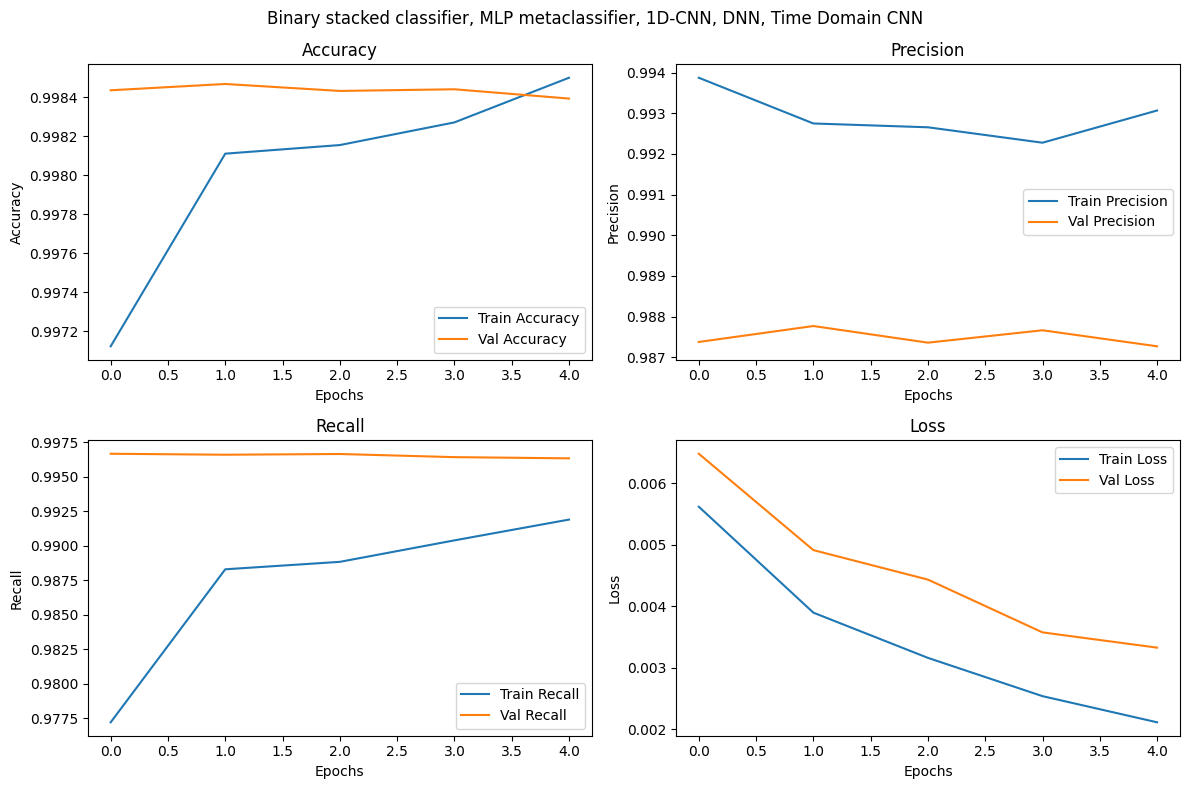

In [48]:
# creating sequences of length 1 from balanced dataset
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files[:15])
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_stacked_dnn_classifier2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Binary stacked classifier, MLP metaclassifier, 1D-CNN, DNN, Time Domain CNN')

203/203 ━━━━━━━━━━━━━━━━━━━━ 130s 487ms/step
Accuracy: 99.870%
Precision: 98.900%
Recall: 99.776%
F1 : 0.99336
Kappa: 0.99263


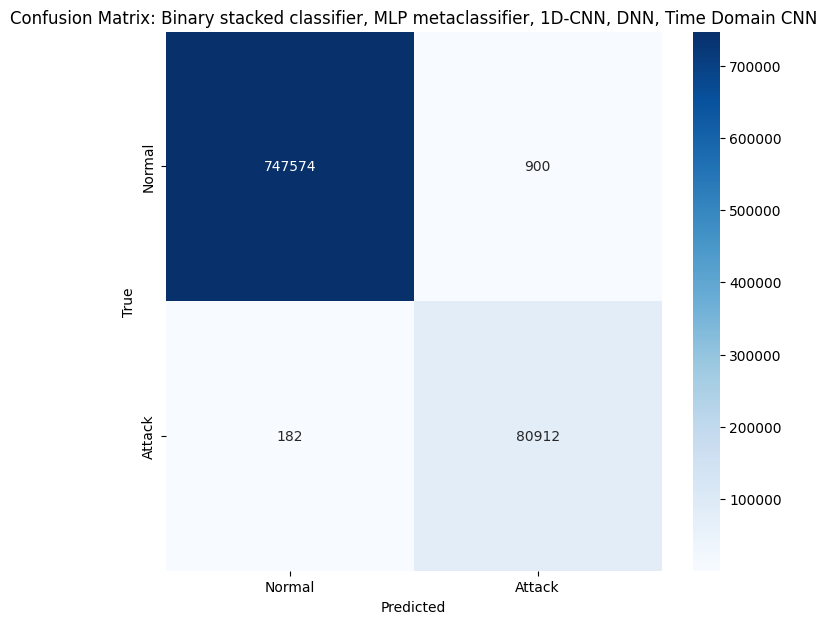

(0.9986957066810678,
 0.9889991688260891,
 0.997755690926579,
 0.9933581329110039,
 0.9926349976356185)

In [49]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP metaclassifier, 1D-CNN, DNN, Time Domain CNN')

### Bottom 3 binary models

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| Time Domain CNN            | 95.407%  | 89.891%   | 64.270% | 0.7495   | 0.7250  |
| 1D-CNN                     | 98.795%  | 89.954%   | 99.884% | 0.9466   | 0.9398  |
| DNN                        | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Arithmetic mean            | 98.824%  | 90.328%   | 99.671% | 0.9477   | 0.9411  |
| Improvement from best      |  0.029%  |  0.374%   | -0.213% | 0.0011   | 0.0013  |
| F1 weighted mean           | 98.788%  | 89.964%   | 99.686% | 0.9458   | 0.9389  |
| Improvement from best      |  0.000%  |  0.010%   | -0.198% | -0.0008  | -0.0007 |
| Kappa weighted mean        | 98.784%  | 90.014%   | 99.683% | 0.9460   | 0.9392  |
| Improvement from best      | -0.004%  |  0.060%   | -0.201% | -0.0006  | -0.0004 |
| Logistic regression        | 98.791%  | 90.069%   | 99.683% | 0.9463   | 0.9395  |
| Improvement from best      |  0.003%  |  0.155%   | -0.201% | -0.0003  | -0.0001 |

In [50]:
import multiclass_cnn_lstm
import data_utils

mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()

if not mul_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_lstm_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_cnn_lstm.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-LSTM")
    print(history)
    #loading best checkpoint
    mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()
    
mul_cnn_lstm_model.name = 'mul_CNN-LSTM'    
mul_cnn_lstm_model.summary()


Model loaded from saved_models/multiclass_cnn_lstm.keras


Model: "mul_CNN-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 24)       │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 16)       │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 16)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 8)        │           136 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 8)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, None, 3)        │            27 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,579 (56.95 KB)

 Trainable params: 4,859 (18.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,720 (37.97 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step
Accuracy: 99.879%
Precision: 99.603%
Recall: 99.548%
F1 : 0.99575
Kappa: 0.99334


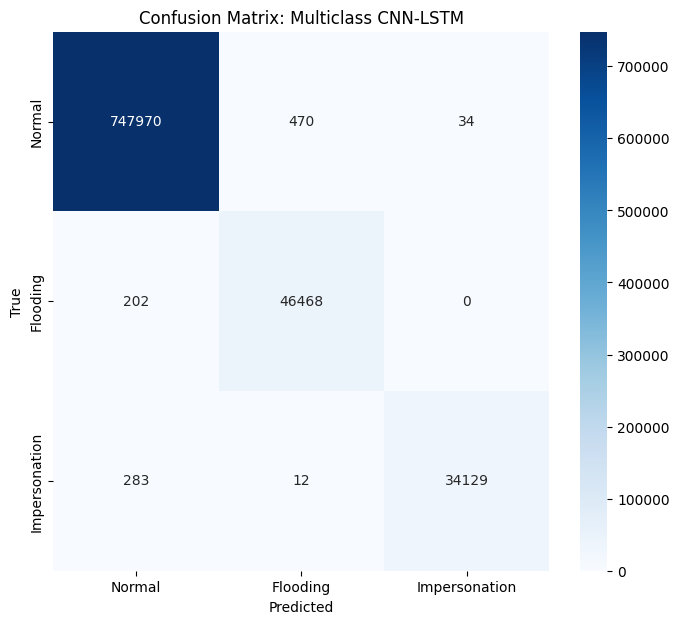

In [51]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_lstm_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-LSTM", binary=False, average='macro')


In [52]:
import multiclass_cnn_gru
import data_utils

mul_cnn_gru_model = multiclass_cnn_gru.multiclass_CNN_GRU_model()

if not mul_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_cnn_gru_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_cnn_gru.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass CNN-GRU")
    print(history)
    #loading best checkpoint
    mul_cnn_gru_model = multiclass_cnn_gru.multiclass_CNN_GRU_lite()
    
mul_cnn_gru_model.name = 'mul_CNN-GRU'    
mul_cnn_gru_model.summary()


Model loaded from saved_models/multiclass_cnn_gru.keras


Model: "mul_CNN-GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 64)       │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 48)       │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 32)       │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 16)       │           528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 3)        │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,395 (165.61 KB)

 Trainable params: 14,131 (55.20 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,264 (110.41 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step
Accuracy: 99.883%
Precision: 99.706%
Recall: 99.485%
F1 : 0.99595
Kappa: 0.99353


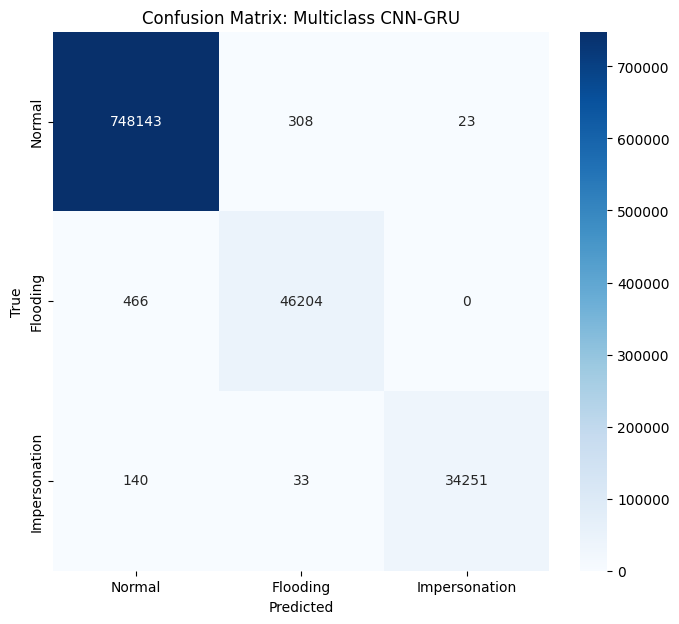

In [53]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_gru_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-GRU", binary=False, average='macro')


In [4]:
import multiclass_td_cnn
import data_utils

mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()

if not mul_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_multiclass_sequential_dataset(x)
    histories = data_utils.step_training(
        train_seq_files,
        val_seq_files,
        mul_td_cnn_model,
        dataset_lambda,
        epochs_per_step=4,
        training_callbacks=[multiclass_td_cnn.checkpoint_callback],
        n_initial_files = 5,
        increment = 0.5
        
    )
    history = defaultdict(list)
    for h in histories:
        for metric, values in h.items():
            history[metric].extend(values) 
    
    plot_model_history(history, "Multiclass Time-Domain CNN")
    print(history)
    #loading best checkpoint
    mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()
    
    
mul_td_cnn_model.summary()


Model loaded from saved_models/multiclass_td_cnn.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         3,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 16)       │         2,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 8)        │           904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 4)        │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 3)        │            15 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,371 (87.39 KB)

 Trainable params: 7,419 (28.98 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 14,840 (57.97 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Accuracy: 98.863%
Precision: 98.742%
Recall: 91.919%
F1 : 0.94869
Kappa: 0.93445


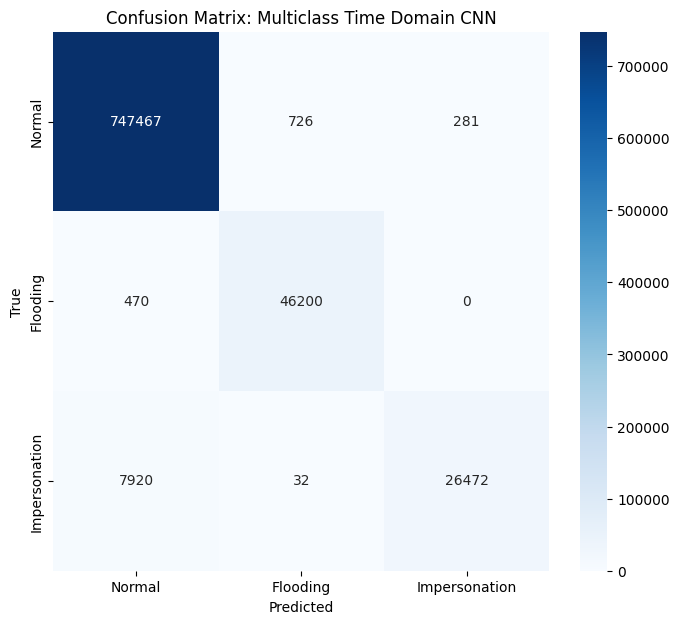

In [5]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_td_cnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass Time Domain CNN", binary=False, average='macro')


Model loaded from saved_models/multiclass_cnn1d.keras


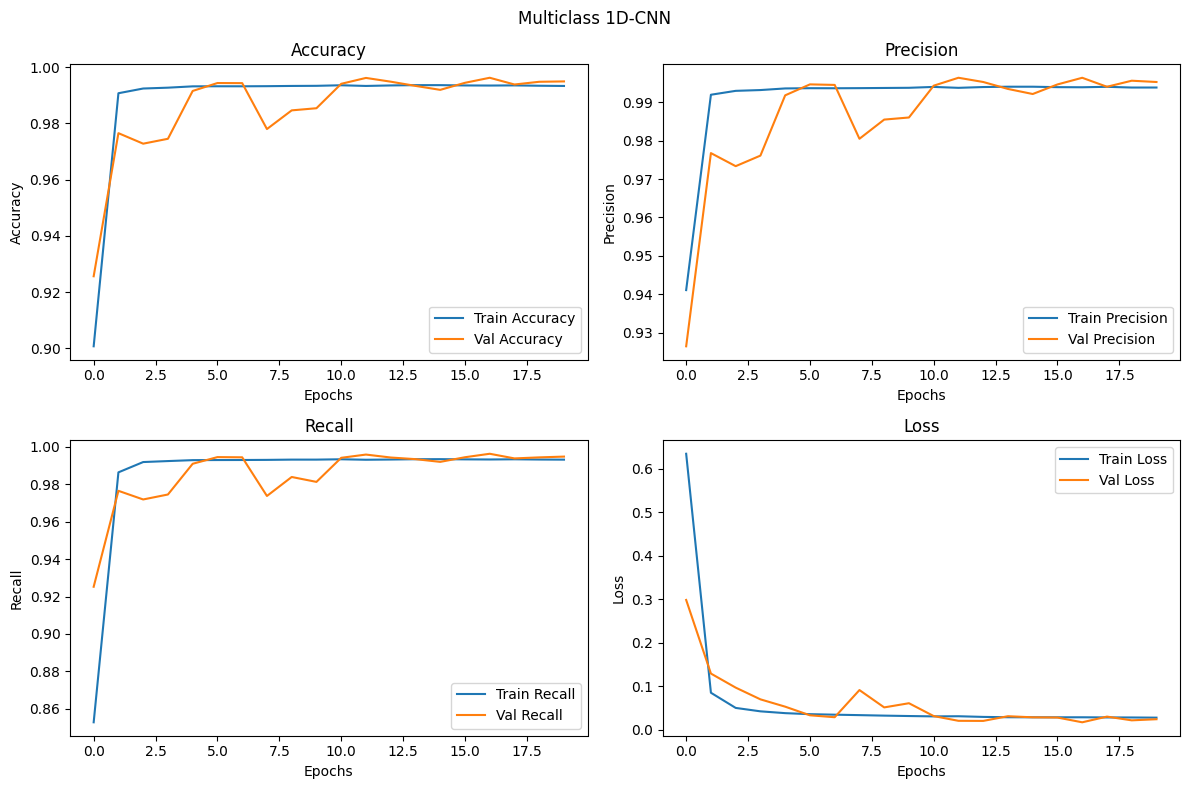

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 39, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 39, 32)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 39, 24)         │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 39, 24)         │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 39, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 39, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 39, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 39, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 624)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         7,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,963 (105.33 KB)

 Trainable params: 8,939 (34.92 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 17,880 (69.85 KB)

In [6]:
import multiclass_cnn1d
import data_utils

mul_cnn1d_model = multiclass_cnn1d.multiclass_CNN1D_model()

if not mul_cnn1d_model.built:
    mul_bal_train_ds = data_utils.create_multiclass_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_multiclass_dataset(val_bal_files)
    history = mul_cnn1d_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=20,
            callbacks = [multiclass_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass 1D-CNN')
else:
    history = {'accuracy': [0.9007068872451782, 0.9907571077346802, 0.9924363493919373, 0.9927367568016052, 0.9932060241699219, 0.993236780166626, 0.9932265281677246, 0.9932692050933838, 0.9933528304100037, 0.9933954477310181, 0.9935917258262634, 0.9933511018753052, 0.9935320019721985, 0.9936361312866211, 0.9936361312866211, 0.9935286045074463, 0.99349445104599, 0.993545651435852, 0.9934244751930237, 0.9933443069458008], 'loss': [0.6346458792686462, 0.08526468276977539, 0.050390712916851044, 0.04251681640744209, 0.03836489096283913, 0.03599055856466293, 0.03482906520366669, 0.03380075842142105, 0.0326605960726738, 0.031728725880384445, 0.030906861647963524, 0.031238794326782227, 0.029723120853304863, 0.028944529592990875, 0.02879839576780796, 0.02880522981286049, 0.02885531075298786, 0.028528690338134766, 0.028405101969838142, 0.028012098744511604], 'precision': [0.9410816431045532, 0.9919870495796204, 0.9930007457733154, 0.9932079911231995, 0.9936286807060242, 0.9936918020248413, 0.9936766624450684, 0.9937059283256531, 0.993752658367157, 0.9937967658042908, 0.9940236806869507, 0.9937861561775208, 0.993992269039154, 0.9940781593322754, 0.9940783977508545, 0.9939639568328857, 0.993934690952301, 0.9940524697303772, 0.9938649535179138, 0.9938679933547974], 'recall': [0.8529016971588135, 0.9862226843833923, 0.9917213320732117, 0.9922417998313904, 0.9927350282669067, 0.9927879571914673, 0.9928135275840759, 0.9928766489028931, 0.993014931678772, 0.993014931678772, 0.993197500705719, 0.9929432272911072, 0.9930610060691833, 0.9932282567024231, 0.9932623505592346, 0.9931514263153076, 0.993086576461792, 0.9931889772415161, 0.9930610060691833, 0.9930012822151184], 'val_accuracy': [0.9256271719932556, 0.9765490889549255, 0.9728077054023743, 0.9745497703552246, 0.991568386554718, 0.9943878650665283, 0.9943503141403198, 0.9780124425888062, 0.9846590757369995, 0.9854202270507812, 0.9941091537475586, 0.9962049722671509, 0.9948703050613403, 0.9933694005012512, 0.9919596910476685, 0.9944682717323303, 0.9962639212608337, 0.9938679337501526, 0.9948327541351318, 0.9949613809585571], 'val_loss': [0.2985839247703552, 0.12935712933540344, 0.09706024825572968, 0.07007023692131042, 0.05325038731098175, 0.03342268988490105, 0.028993023559451103, 0.09140735864639282, 0.05155725032091141, 0.06116659566760063, 0.03162522614002228, 0.02073124423623085, 0.020512443035840988, 0.03131570294499397, 0.0287551898509264, 0.028245512396097183, 0.01732785999774933, 0.03038383275270462, 0.02181694470345974, 0.024393843486905098], 'val_precision': [0.9264398217201233, 0.9767805933952332, 0.9733746647834778, 0.9761265516281128, 0.9918332695960999, 0.9946862459182739, 0.9945470094680786, 0.9805127382278442, 0.9855123162269592, 0.986058235168457, 0.9943482279777527, 0.9964115023612976, 0.9953096508979797, 0.9934965968132019, 0.9921765923500061, 0.9946699142456055, 0.996407687664032, 0.9940638542175293, 0.9956412315368652, 0.9953066110610962], 'val_recall': [0.9251983165740967, 0.976372241973877, 0.9717624187469482, 0.974410355091095, 0.9908018708229065, 0.9943556785583496, 0.9942485094070435, 0.9736224412918091, 0.9837532043457031, 0.9811374545097351, 0.9939804673194885, 0.9957118630409241, 0.9941359162330627, 0.9932675957679749, 0.9918149709701538, 0.9942860007286072, 0.9961406588554382, 0.9936589002609253, 0.994210958480835, 0.9946237206459045]}
    plot_model_history(history, 'Multiclass 1D-CNN')

mul_cnn1d_model.summary()



25924/25924 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
Accuracy: 99.530%
Precision: 97.438%
Recall: 99.738%
F1 : 0.98541
Kappa: 0.97457


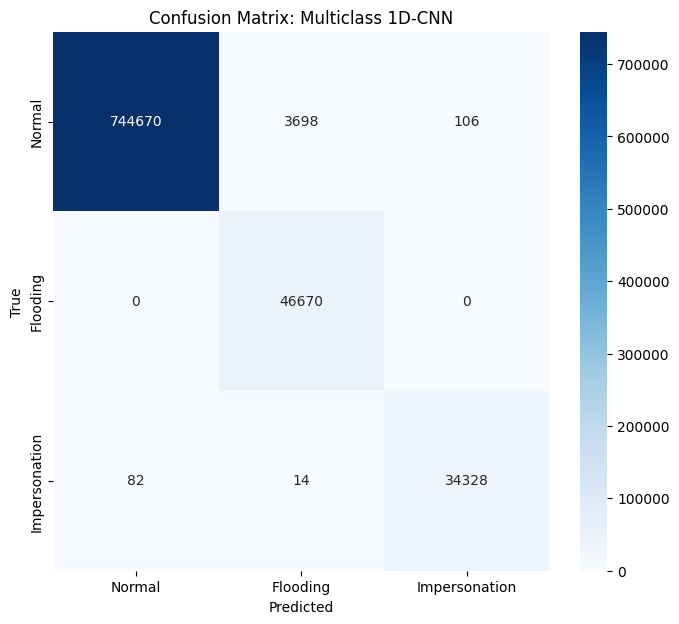

In [7]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn1d_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
y_true = tf.argmax(labels, axis=1).numpy().flatten()
    
mul_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass 1D-CNN", binary=False, average='macro')


Model loaded from saved_models/multiclass_dnn.keras


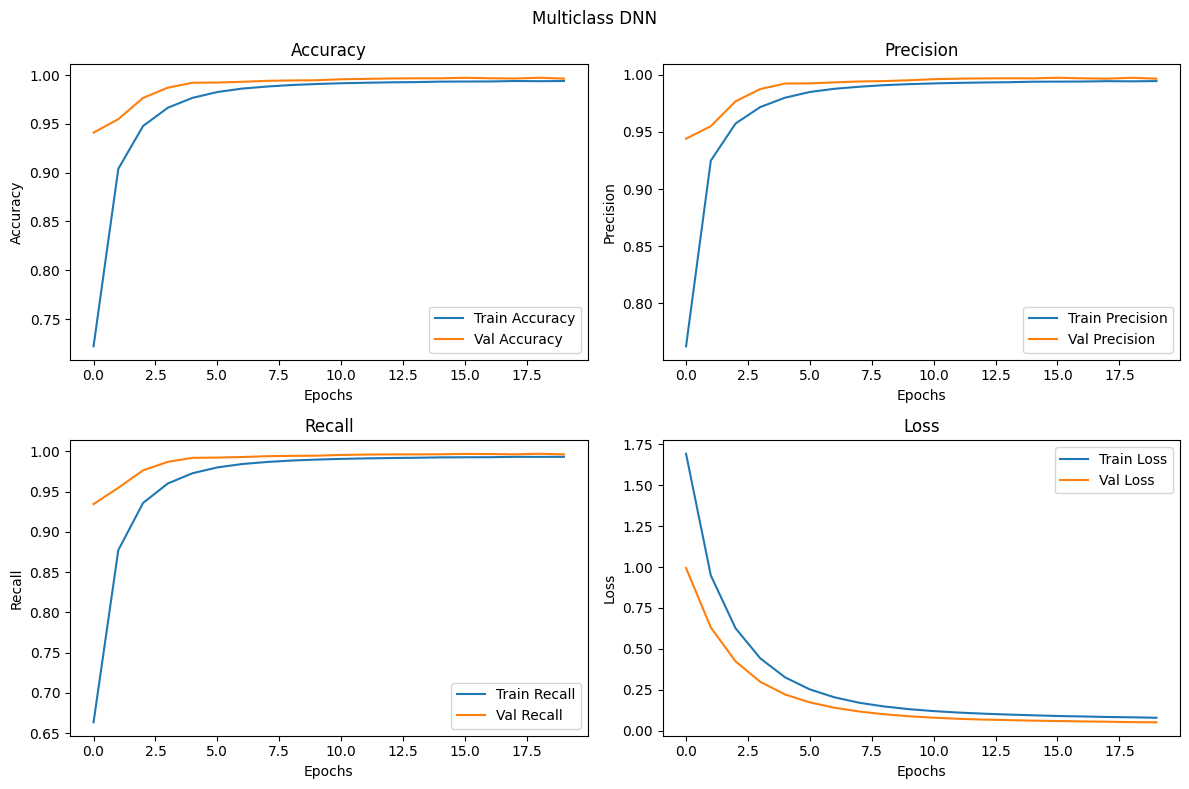

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,963 (23.30 KB)

 Trainable params: 1,955 (7.64 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 3,912 (15.29 KB)

In [8]:
import multiclass_dnn
import data_utils

mul_dnn_model = multiclass_dnn.multiclass_DNN_model()

if not mul_dnn_model.built:
    mul_bal_train_ds = data_utils.create_multiclass_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_multiclass_dataset(val_bal_files)
    history = mul_dnn_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=20,
            callbacks = [multiclass_dnn.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass DNN')
else:
    history = {'accuracy': [0.7220519185066223, 0.9039101600646973, 0.947839617729187, 0.9665456414222717, 0.9766930341720581, 0.9826541543006897, 0.9861680269241333, 0.9882705807685852, 0.9898287057876587, 0.9908697009086609, 0.9916496276855469, 0.9921547770500183, 0.992583155632019, 0.9928220510482788, 0.9933016300201416, 0.9934176802635193, 0.9934910535812378, 0.9939296245574951, 0.9937521815299988, 0.9939313530921936], 'loss': [1.6919828653335571, 0.9487369656562805, 0.6259369254112244, 0.44205474853515625, 0.32610949873924255, 0.2525869607925415, 0.20395369827747345, 0.1709052473306656, 0.14834415912628174, 0.13202162086963654, 0.12000031769275665, 0.11117128282785416, 0.10444305092096329, 0.09908243268728256, 0.09451992064714432, 0.0900607705116272, 0.08751488476991653, 0.08414887636899948, 0.08214396983385086, 0.0794513002038002], 'precision': [0.7624614834785461, 0.9249007105827332, 0.9574190378189087, 0.9718499779701233, 0.9799951314926147, 0.9850008487701416, 0.9878191947937012, 0.9895879030227661, 0.9909629225730896, 0.9918545484542847, 0.9924875497817993, 0.992963969707489, 0.9933183789253235, 0.9935497045516968, 0.9939773678779602, 0.9940665364265442, 0.9941434860229492, 0.9944621324539185, 0.9943258166313171, 0.9945473670959473], 'recall': [0.66331946849823, 0.8772667646408081, 0.9358986020088196, 0.9601339101791382, 0.9728822112083435, 0.9800772070884705, 0.9842925071716309, 0.9868165254592896, 0.9886443018913269, 0.9897928237915039, 0.9906802773475647, 0.9913151264190674, 0.9917554259300232, 0.9920694231987, 0.9925575256347656, 0.9927026033401489, 0.9927862286567688, 0.9932470321655273, 0.9931702017784119, 0.9932947754859924], 'val_accuracy': [0.9410645365715027, 0.9548456072807312, 0.9766241312026978, 0.9871301651000977, 0.992163360118866, 0.9923617243766785, 0.9931336045265198, 0.9941251873970032, 0.994505763053894, 0.9947148561477661, 0.9957225322723389, 0.9961245656013489, 0.9965319633483887, 0.9967195391654968, 0.9967249035835266, 0.997223436832428, 0.9967731833457947, 0.9965105056762695, 0.9972716569900513, 0.9963711500167847], 'val_loss': [0.9941380023956299, 0.6306169033050537, 0.4239323139190674, 0.298564076423645, 0.22166921198368073, 0.17330124974250793, 0.1404879093170166, 0.11749791353940964, 0.10074111074209213, 0.08856925368309021, 0.07992453873157501, 0.07300786674022675, 0.06837501376867294, 0.06514357775449753, 0.061845388263463974, 0.05951591581106186, 0.05727886036038399, 0.05519590154290199, 0.052739933133125305, 0.05168865993618965], 'val_precision': [0.9441640377044678, 0.95506751537323, 0.9768344759941101, 0.9876103401184082, 0.992379903793335, 0.9925422072410583, 0.9934255480766296, 0.9942046403884888, 0.9945693612098694, 0.9952320456504822, 0.9962186217308044, 0.9966531991958618, 0.9968836903572083, 0.9970014691352844, 0.9969322681427002, 0.9974470138549805, 0.9969545602798462, 0.9966383576393127, 0.9974368214607239, 0.9966434240341187], 'val_recall': [0.9344875812530518, 0.954770565032959, 0.9764365553855896, 0.9870068430900574, 0.9919596910476685, 0.9923134446144104, 0.9929995536804199, 0.9940341114997864, 0.9944307208061218, 0.9946558475494385, 0.9955724477767944, 0.9960441589355469, 0.9962317943572998, 0.9962853789329529, 0.9963818788528442, 0.9968588948249817, 0.9966766834259033, 0.9964032769203186, 0.9970518946647644, 0.9963282346725464]}
    plot_model_history(history, 'Multiclass DNN')

mul_dnn_model.summary()



25924/25924 ━━━━━━━━━━━━━━━━━━━━ 16s 595us/step
Accuracy: 99.676%
Precision: 97.780%
Recall: 99.792%
F1 : 0.98765
Kappa: 0.98238


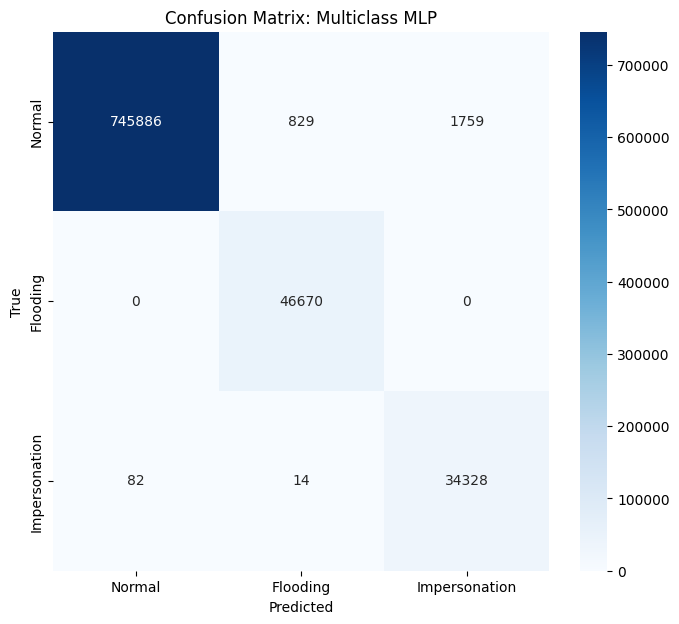

In [9]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
y_true = tf.argmax(labels, axis=1).numpy().flatten()
    
mul_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass MLP", binary=False, average='macro')


### Multiclass Models performance

* CNN-LSTM
    * Accuracy: 99.238%
    * Precision: 96.198%
    * Recall: 99.089%
    * F1 : 0.9754
    * Kappa: 0.9509
* CNN-GRU
    * Accuracy: 99.032%
    * Precision: 94.927%
    * Recall: 99.077%
    * F1 : 0.9684
    * Kappa: 0.9384
* Time Domain CNN
    * Accuracy: 96.971%
    * Precision: 78.809%
    * Recall: 69.121%
    * F1 : 0.7053
    * Kappa: 0.7790
* 1D-CNN
    * Accuracy: 98.807%
    * Precision: 93.063%
    * Recall: 99.281%
    * F1 : 0.9593
    * Kappa: 0.9253
* DNN
    * Accuracy: 98.873%
    * Precision: 94.268%
    * Recall: 99.370%
    * F1 : 0.9659
    * Kappa: 0.9292


In [60]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
#combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

mul_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate1.summary()

Model: "functional_108"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      4,859 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │     14,131 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, None, 3)   │      2,051 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_2 (Average) │ (None, None, 3)   │          0 │ mul_CNN-LSTM[0][… │
│                     │                   │            │ mul_CNN-GRU[0][0… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,041 (82.19 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,041 (82.19 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 125s 217ms/step
(829568,) (829568,)
Accuracy: 99.891%
Precision: 99.412%
Recall: 99.857%
F1 : 0.99633
Kappa: 0.99402


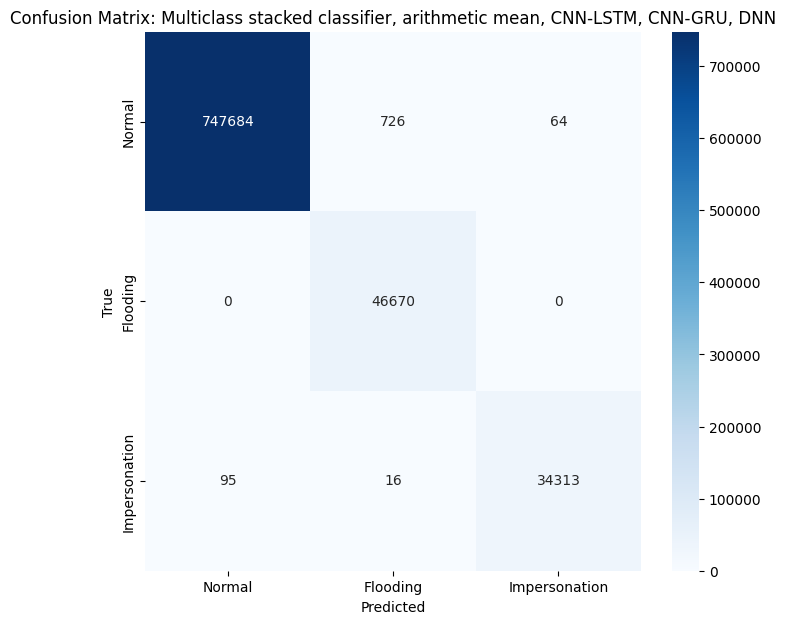

In [61]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_arithmetic_mean_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
print(y_pred.shape, y_true.shape)
    

    
mul_arithmetic_mean_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, arithmetic mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [62]:
import math
from keras.layers import Input, Dense, TimeDistributed, Lambda

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

mul_f1_weights = [
    mul_cnn_lstm_metrics[3],
    mul_cnn_gru_metrics[3],
    mul_dnn_metrics[3],
]

mul_f1_weights = [math.log(w / (1 - w)) for w in mul_f1_weights]

sum_mul_f1_weights = sum(mul_f1_weights)

mul_f1_weights = tf.constant([w / sum_mul_f1_weights for w in mul_f1_weights], dtype=tf.float32, shape=(len(mul_f1_weights), 1))

print('F1 calculated_weights')
print(mul_f1_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_f1_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_f1_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_f1_weighted_aggregate1.summary()

F1 calculated_weights
[[0.3555598]
 [0.3588583]
 [0.2855819]]



Model: "functional_109"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      4,859 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │     14,131 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, None, 3)   │      2,051 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, None, 3,   │          0 │ mul_CNN-LSTM[1][… │
│                     │ 3)                │            │ mul_CNN-GRU[1][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, None, 3)   │          0 │ lambda_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, None, 3)   │          0 │ lambda_11[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,041 (82.19 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,041 (82.19 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 46s 119ms/step
Accuracy: 99.893%
Precision: 99.437%
Recall: 99.846%
F1 : 0.99639
Kappa: 0.99413


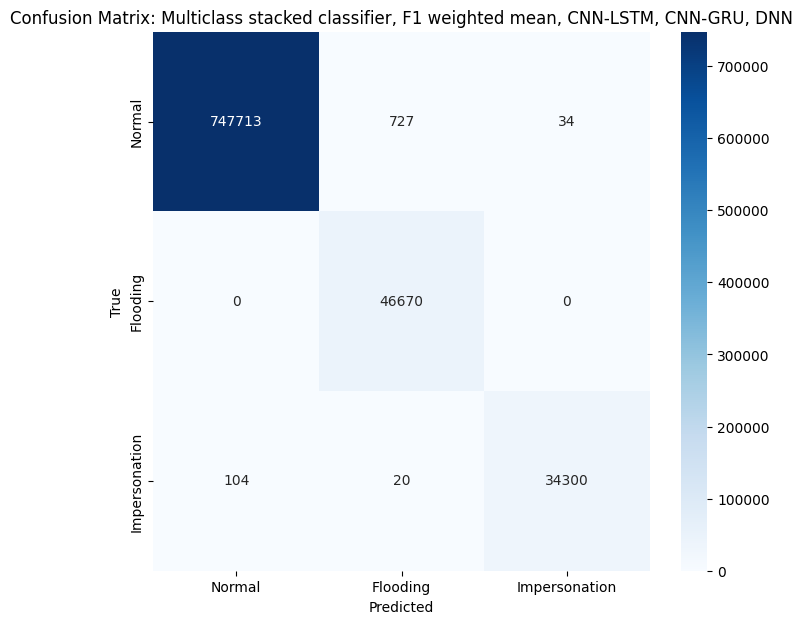

In [63]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_f1_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_f1_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, F1 weighted mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [64]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

mul_kappa_weights = [
    mul_cnn_lstm_metrics[4],
    mul_cnn_gru_metrics[4],
    mul_dnn_metrics[4],
]

mul_kappa_weights = [math.log(w / (1 - w)) for w in mul_kappa_weights]

sum_mul_kappa_weights = sum(mul_kappa_weights)

mul_kappa_weights = tf.constant([w / sum_mul_kappa_weights for w in mul_kappa_weights], dtype=tf.float32,  shape=(len(mul_kappa_weights), 1))

print('Cohe Kappa calculated_weights')
print(mul_kappa_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_kappa_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_kappa_weighted_aggregate1.summary()

Cohe Kappa calculated_weights
[[0.35593402]
 [0.3580684 ]
 [0.28599757]]


Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      4,859 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │     14,131 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, None, 3)   │      2,051 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, None, 3,   │          0 │ mul_CNN-LSTM[2][… │
│                     │ 3)                │            │ mul_CNN-GRU[2][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, None, 3)   │          0 │ lambda_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, None, 3)   │          0 │ lambda_14[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,041 (82.19 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,041 (82.19 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 179s 817ms/step
Accuracy: 99.893%
Precision: 99.438%
Recall: 99.846%
F1 : 0.99640
Kappa: 0.99414


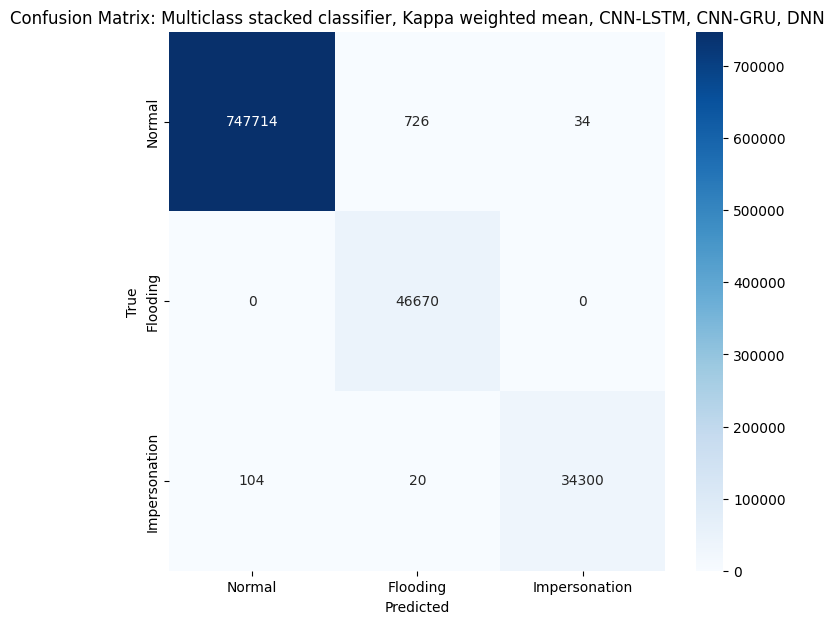

In [65]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_kappa_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_kappa_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [66]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
from tensorflow.keras.initializers import RandomUniform
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(3, activation='softmax', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(y)

mul_softmax_regression1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_softmax_regression1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_softmax_regression1.summary()

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      4,859 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │     14,131 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, None, 3)   │      2,051 │ input_layer_11[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, None, 9)   │          0 │ mul_CNN-LSTM[3][… │
│ (Concatenate)       │                   │            │ mul_CNN-GRU[3][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, None, 3)   │         30 │ concatenate_12[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,071 (82.31 KB)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 21,041 (82.19 KB)

Epoch 1/5
    299/Unknown 47s 78ms/step - accuracy: 0.8784 - loss: 0.0663 - precision: 0.6889 - recall: 0.3016

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 91s 229ms/step - accuracy: 0.8787 - loss: 0.0662 - precision: 0.6900 - recall: 0.3027 - val_accuracy: 0.9981 - val_loss: 0.0116 - val_precision: 0.9997 - val_recall: 0.9645
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 106s 322ms/step - accuracy: 0.9990 - loss: 0.0086 - precision: 0.9999 - recall: 0.9857 - val_accuracy: 0.9986 - val_loss: 0.0038 - val_precision: 0.9992 - val_recall: 0.9972
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 61s 168ms/step - accuracy: 0.9993 - loss: 0.0032 - precision: 0.9998 - recall: 0.9976 - val_accuracy: 0.9986 - val_loss: 0.0020 - val_precision: 0.9989 - val_recall: 0.9979
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 58s 167ms/step - accuracy: 0.9993 - loss: 0.0018 - precision: 0.9998 - recall: 0.9983 - val_accuracy: 0.9987 - val_loss: 0.0013 - val_precision: 0.9988 - val_recall: 0.9983
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 57s 165ms/step - accuracy: 0.9995 - loss: 0.0012 - precision: 0.9998 - recall: 0.9987 - val_accuracy: 0.9987 - val_loss: 9

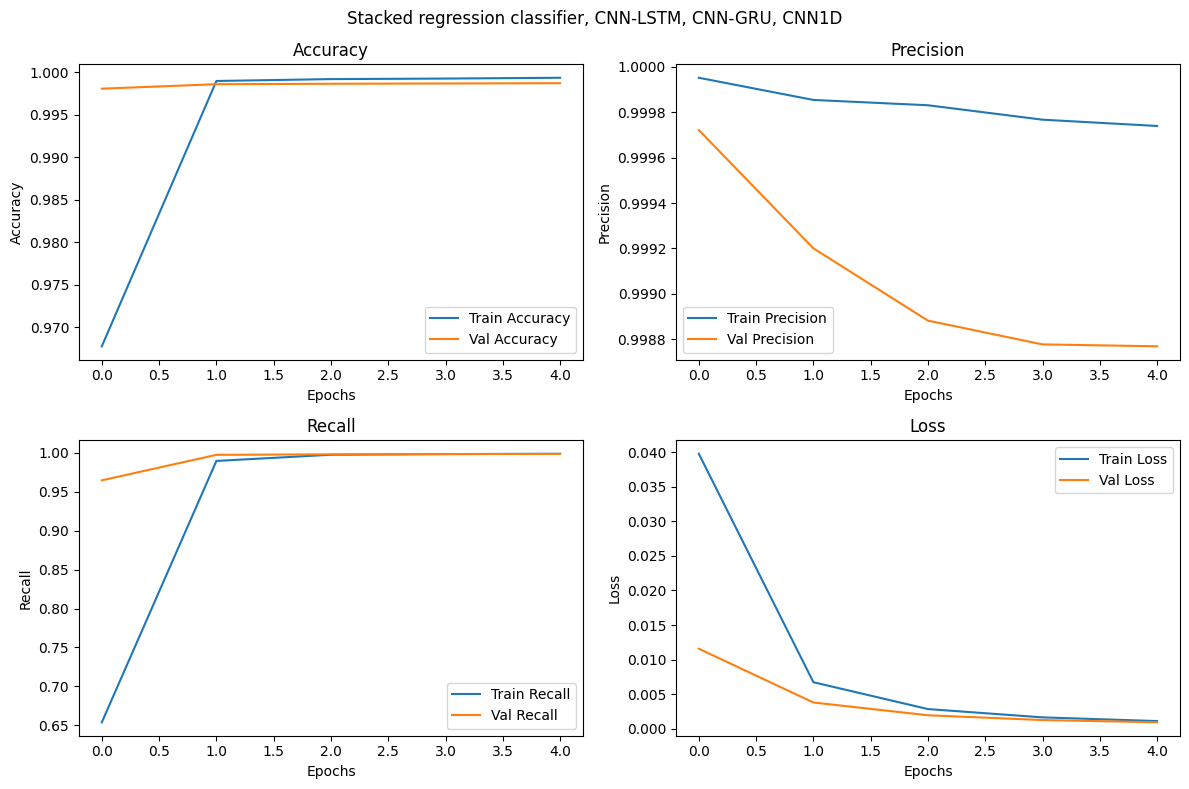

In [67]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files[:15])
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)

history = mul_softmax_regression1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Stacked regression classifier, CNN-LSTM, CNN-GRU, CNN1D')

In [68]:
output_layer = mul_softmax_regression1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Softmax regressor weights:\n", output_weights)
print("Softmax regressor bias: ", output_bias)

Softmax regressor weights:
 [[1.3281077  0.5669364  0.6876845 ]
 [0.43687412 1.5827132  0.5972011 ]
 [0.5763006  0.5886503  1.4164029 ]
 [1.3085394  0.68266994 0.6111576 ]
 [0.45270994 1.5145115  0.5734694 ]
 [0.4714913  0.69069797 1.516841  ]
 [1.3661549  0.6523526  0.7159438 ]
 [0.4500666  1.5526406  0.5545882 ]
 [0.7335578  0.6084655  1.326368  ]]
Softmax regressor bias:  [-1.2172604 -1.8614361 -1.8066227]


203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 118ms/step
Accuracy: 99.892%
Precision: 99.453%
Recall: 99.821%
F1 : 0.99635
Kappa: 0.99405


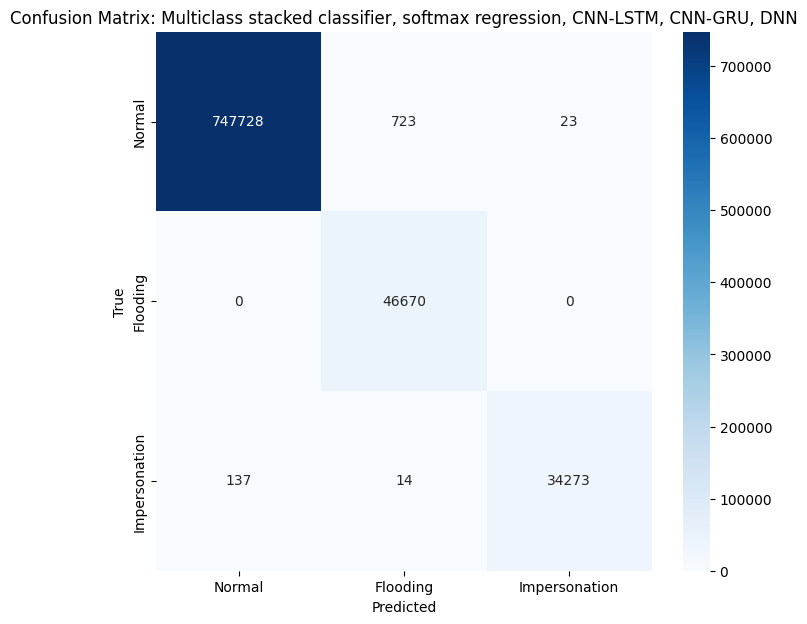

In [69]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_softmax_regression1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_softmax_regression1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, softmax regression, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [70]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Dense
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_dnn_classifier1.summary()

Model: "functional_112"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      4,859 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │     14,131 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, None, 3)   │      2,051 │ input_layer_12[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, None, 9)   │          0 │ mul_CNN-LSTM[4][… │
│ (Concatenate)       │                   │            │ mul_CNN-GRU[4][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, None, 4)   │         40 │ concatenate_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, None, 3)   │         15 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,116 (82.48 KB)

 Trainable params: 75 (300.00 B)

 Non-trainable params: 21,041 (82.19 KB)

Epoch 1/5
    299/Unknown 47s 95ms/step - accuracy: 0.4849 - loss: 0.0928 - precision: 0.4879 - recall: 0.1303

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 84s 218ms/step - accuracy: 0.4857 - loss: 0.0927 - precision: 0.4896 - recall: 0.1313 - val_accuracy: 0.9027 - val_loss: 0.0161 - val_precision: 0.9994 - val_recall: 0.9015
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 72s 210ms/step - accuracy: 0.9139 - loss: 0.0142 - precision: 0.9991 - recall: 0.9112 - val_accuracy: 0.9341 - val_loss: 0.0079 - val_precision: 0.9996 - val_recall: 0.9326
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 72s 210ms/step - accuracy: 0.9424 - loss: 0.0086 - precision: 0.9998 - recall: 0.9186 - val_accuracy: 0.9987 - val_loss: 0.0055 - val_precision: 0.9997 - val_recall: 0.9327
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 29284s 98s/step - accuracy: 0.9993 - loss: 0.0061 - precision: 0.9998 - recall: 0.9177 - val_accuracy: 0.9986 - val_loss: 0.0040 - val_precision: 0.9997 - val_recall: 0.9326
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 124s 350ms/step - accuracy: 0.9994 - loss: 0.0043 - precision: 0.9998 - recall: 0.9239 - val_accuracy: 0.9986 - val_loss: 

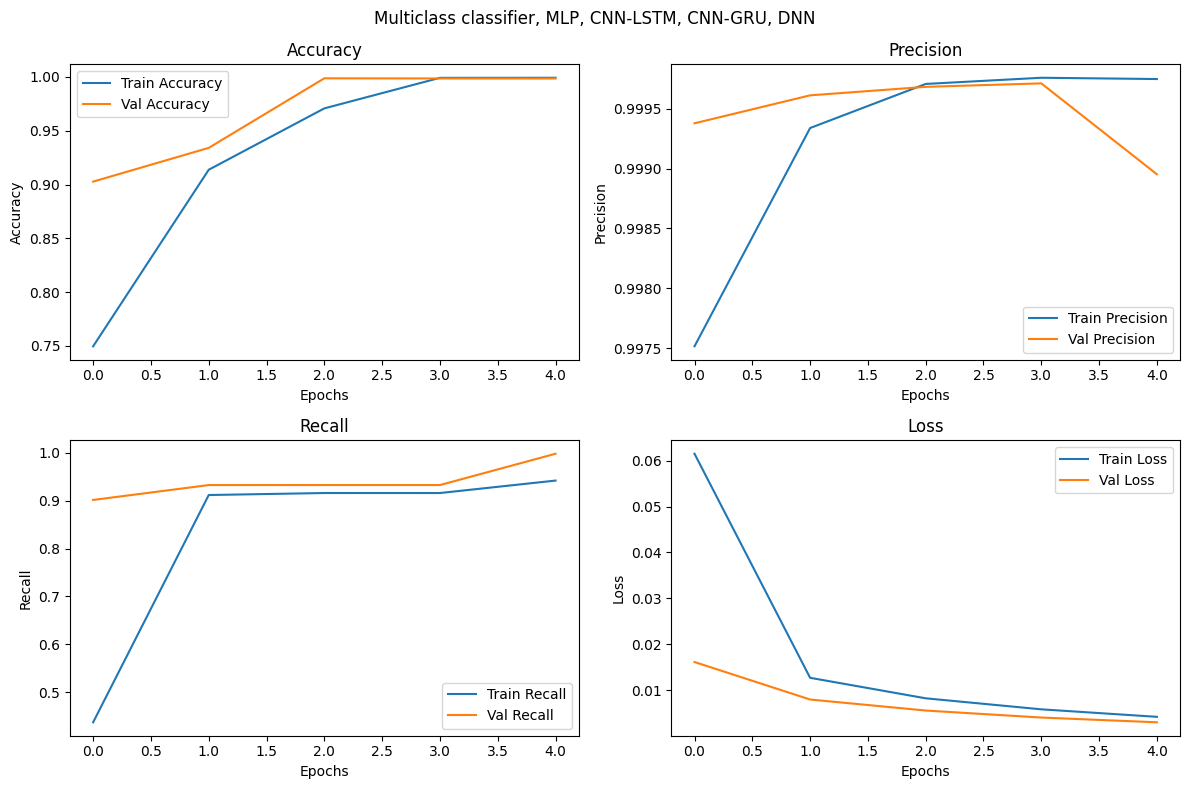

In [71]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files[:15])
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)

history = mul_dnn_classifier1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass classifier, MLP, CNN-LSTM, CNN-GRU, DNN')

203/203 ━━━━━━━━━━━━━━━━━━━━ 451s 223ms/step
Accuracy: 99.886%
Precision: 99.424%
Recall: 99.792%
F1 : 0.99605
Kappa: 0.99375


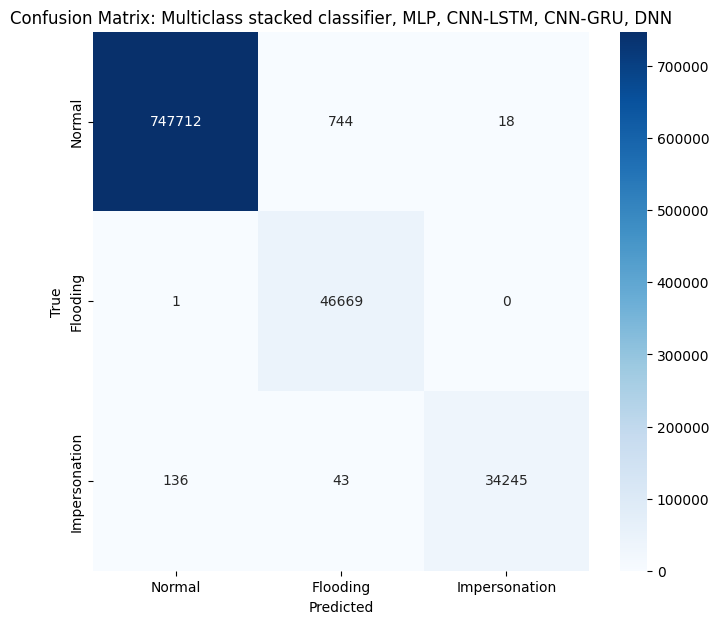

In [72]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_classifier1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_dnn_classifier1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, MLP, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

### Top 3 Multiclass models

|                       | Accuracy | Precision | Recall  | F1      | Kappa   |
|-----------------------|----------|-----------|---------|---------|---------|
| CNN-LSTM              | 99.238%  | 96.198%   | 99.089% | 0.9754  | 0.9509  |
| CNN-GRU               | 99.032%  | 94.927%   | 99.077% | 0.9684  | 0.9384  |
| DNN                   | 98.873%  | 94.268%   | 99.370% | 0.9659  | 0.9292  |
| Arithmetic mean       | 99.078%  | 95.200%   | 99.497% | 0.9719  | 0.9414  |
| Improvement from best | -0.160%  | -0.902%   |  0.408% | -0.0030 | -0.0095 |
| F1 weighted mean      | 99.080%  | 95.244%   | 99.486% | 0.9720  | 0.9415  |
| Improvement from best | -0.158%  | -0.858%   |  0.397% | -0.0029 | -0.0094 |
| Kappa weighted mean   | 99.081%  | 95.260%   | 99.481% | 0.9721  | 0.9416  |
| Improvement from best | -0.157%  | -0.842%   |  0.392% | -0.0028 | -0.0093 |
| Softmax regression    | 99.073%  | 95.160%   | 99.481% | 0.9715  | 0.9411  |
| Improvement from best | -0.165%  | -0.942%   |  0.392% | -0.0034 | -0.0098 |
| MLP                   | 99.076%  | 95.189%   | 99.490% | 0.9718  | 0.9413  |
| Improvement from best | -0.162%  | -0.913%   |  0.401% | -0.0031 | -0.0096 |

In [73]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
#combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

mul_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate2.summary()

Model: "functional_113"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      7,531 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_32 │ (None, None, 3)   │      2,051 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, None, 3)   │      9,083 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_3 (Average) │ (None, None, 3)   │          0 │ sequential[0][0], │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,665 (72.91 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,665 (72.91 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 147s 458ms/step
(829568,) (829568,)
Accuracy: 99.851%
Precision: 99.109%
Recall: 99.856%
F1 : 0.99479
Kappa: 0.99185


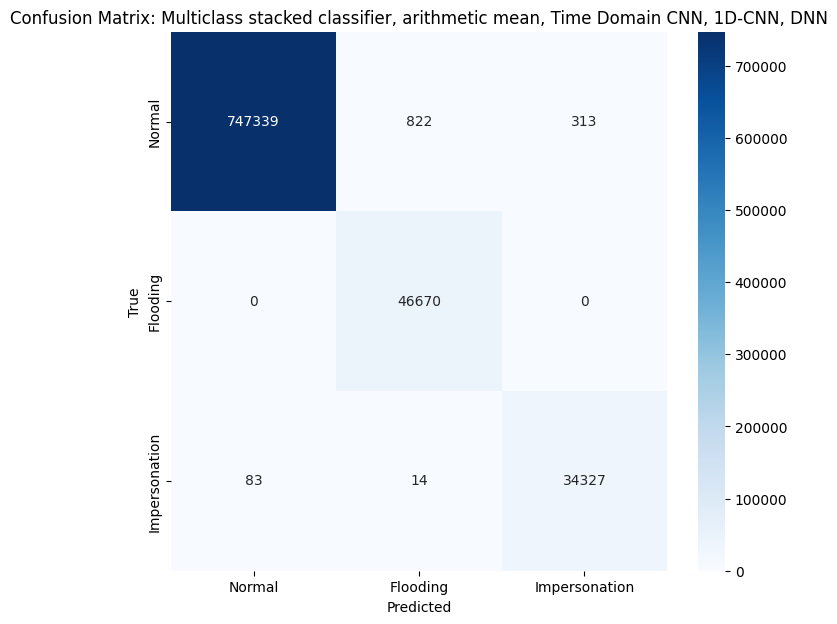

In [74]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_arithmetic_mean_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
print(y_pred.shape, y_true.shape)
    
mul_arithmetic_mean_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, arithmetic mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [75]:
import math
from keras.layers import Input, Dense, TimeDistributed, Lambda

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

mul_f1_weights = [
    mul_td_cnn_metrics[3],
    mul_dnn_metrics[3],
    mul_cnn1d_metrics[3],
]

mul_f1_weights = [math.log(w / (1 - w)) for w in mul_f1_weights]

sum_mul_f1_weights = sum(mul_f1_weights)

mul_f1_weights = tf.constant([w / sum_mul_f1_weights for w in mul_f1_weights], dtype=tf.float32, shape=(len(mul_f1_weights), 1))

print('F1 calculated_weights')
print(mul_f1_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_f1_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_f1_weighted_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_f1_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_f1_weighted_aggregate2.summary()

F1 calculated_weights
[[0.25341386]
 [0.38065082]
 [0.36593533]]


Model: "functional_114"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      7,531 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_34 │ (None, None, 3)   │      2,051 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, None, 3)   │      9,083 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, None, 3,   │          0 │ sequential[1][0], │
│                     │ 3)                │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, None, 3)   │          0 │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, None, 3)   │          0 │ lambda_17[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,665 (72.91 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,665 (72.91 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 452s 326ms/step
Accuracy: 99.779%
Precision: 98.612%
Recall: 99.830%
F1 : 0.99214
Kappa: 0.98790


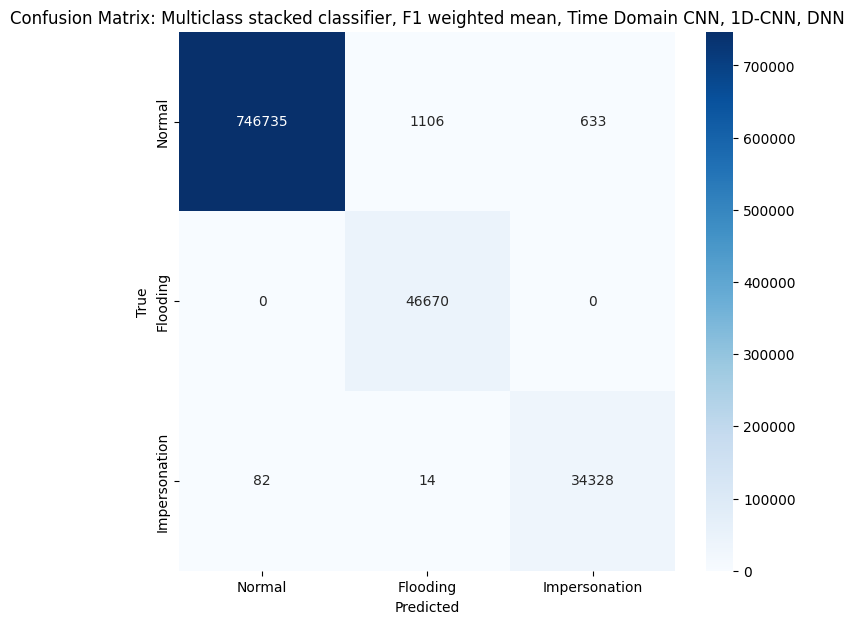

In [76]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_f1_weighted_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_f1_weighted_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, F1 weighted mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [13]:
from keras.layers import Input, Dense, TimeDistributed, Lambda
import math

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

mul_kappa_weights = [
    mul_td_cnn_metrics[4],
    mul_dnn_metrics[4],
    mul_cnn1d_metrics[4],
]

mul_kappa_weights = [math.log(w / (1 - w)) for w in mul_kappa_weights]

sum_mul_kappa_weights = sum(mul_kappa_weights)

mul_kappa_weights = tf.constant([w / sum_mul_kappa_weights for w in mul_kappa_weights], dtype=tf.float32,  shape=(len(mul_kappa_weights), 1))

print('Cohe Kappa calculated_weights')
print(mul_kappa_weights.numpy())

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_kappa_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

mul_kappa_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_kappa_weighted_aggregate2.summary()

Cohe Kappa calculated_weights
[[0.25737035]
 [0.3894799 ]
 [0.3531497 ]]



Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      7,531 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, None, 3)   │      2,051 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, None, 3)   │      9,083 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 3,   │          0 │ sequential[1][0], │
│                     │ 3)                │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, None, 3)   │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 3)   │          0 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,665 (72.91 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,665 (72.91 KB)

203/203 ━━━━━━━━━━━━━━━━━━━━ 90s 284ms/step
Accuracy: 99.781%
Precision: 98.649%
Recall: 99.831%
F1 : 0.99233
Kappa: 0.98804


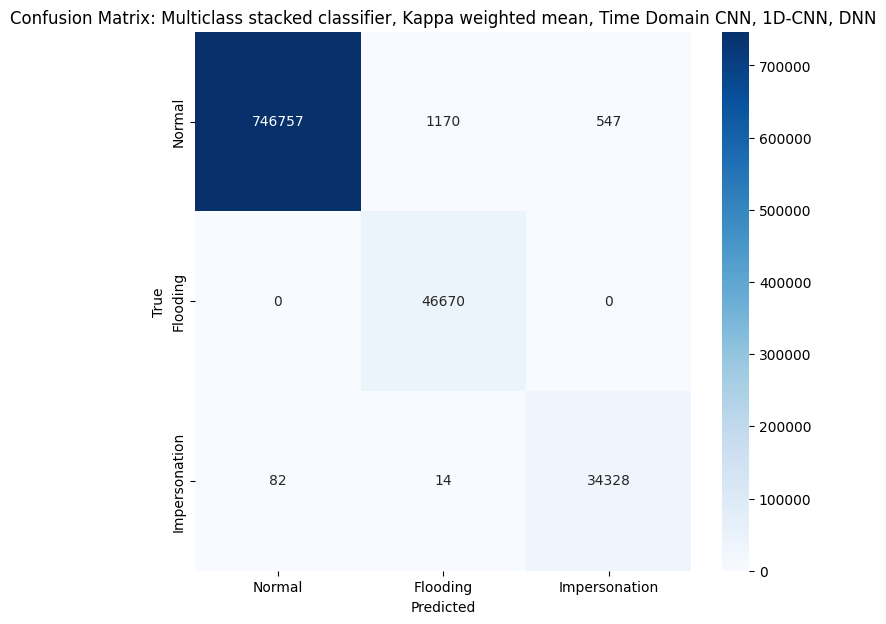

In [14]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_kappa_weighted_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_kappa_weighted_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [15]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
from tensorflow.keras.initializers import RandomNormal
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(3, activation='softmax', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-0.5)))(y)

mul_softmax_regression2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_softmax_regression2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_softmax_regression2.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      7,531 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None, 3)   │      2,051 │ input_layer_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, None, 3)   │      9,083 │ input_layer_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 9)   │          0 │ sequential[2][0], │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, None, 3)   │         30 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,695 (73.03 KB)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 18,665 (72.91 KB)

Epoch 1/5
    299/Unknown 67s 128ms/step - accuracy: 0.7375 - loss: 0.0772 - precision: 0.6321 - recall: 0.2340

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 115s 289ms/step - accuracy: 0.7381 - loss: 0.0771 - precision: 0.6333 - recall: 0.2352 - val_accuracy: 0.9973 - val_loss: 0.0141 - val_precision: 0.9991 - val_recall: 0.9646
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 79s 210ms/step - accuracy: 0.9947 - loss: 0.0109 - precision: 0.9996 - recall: 0.9787 - val_accuracy: 0.9985 - val_loss: 0.0047 - val_precision: 0.9987 - val_recall: 0.9966
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 66s 192ms/step - accuracy: 0.9985 - loss: 0.0042 - precision: 0.9996 - recall: 0.9949 - val_accuracy: 0.9986 - val_loss: 0.0025 - val_precision: 0.9987 - val_recall: 0.9976
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - accuracy: 0.9985 - loss: 0.0024 - precision: 0.9994 - recall: 0.9967 - val_accuracy: 0.9986 - val_loss: 0.0016 - val_precision: 0.9987 - val_recall: 0.9980
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 89s 269ms/step - accuracy: 0.9987 - loss: 0.0016 - precision: 0.9994 - recall: 0.9970 - val_accuracy: 0.9986 - val_loss: 0

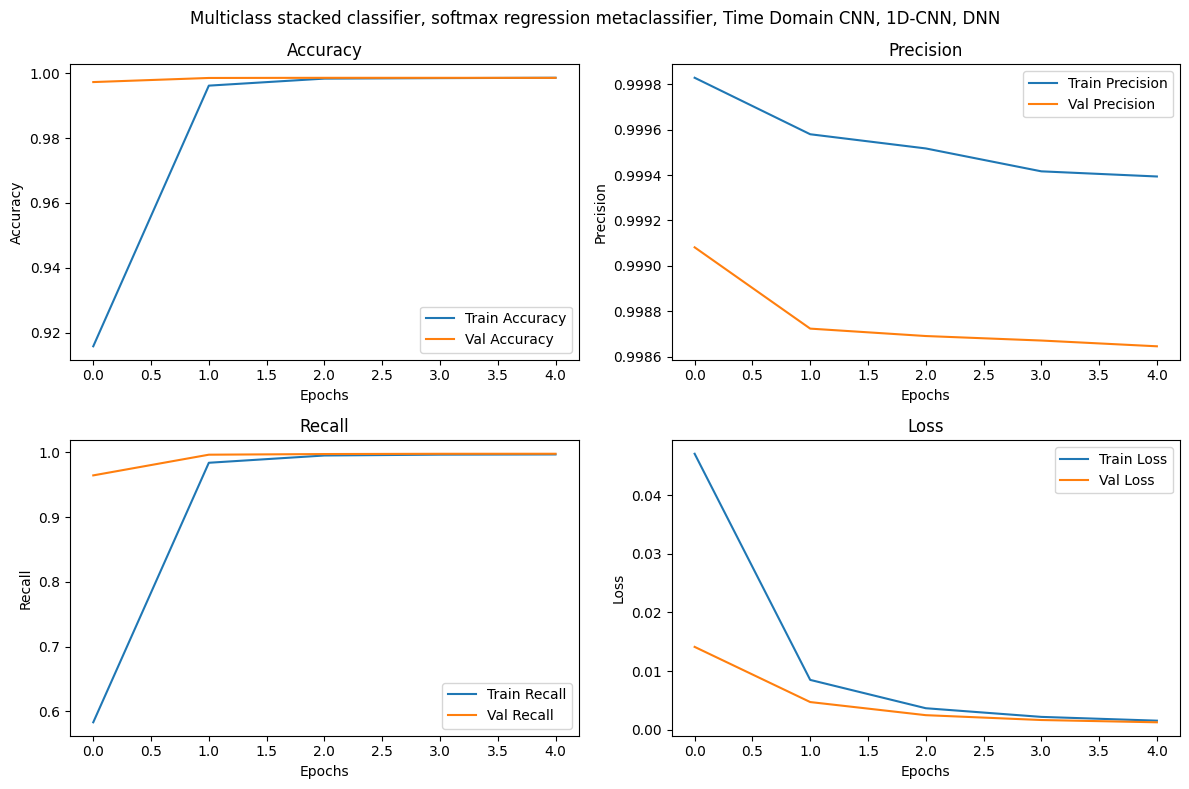

In [16]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files[:15])
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)

history = mul_softmax_regression2.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass stacked classifier, softmax regression metaclassifier, Time Domain CNN, 1D-CNN, DNN')

In [17]:
output_layer = mul_softmax_regression2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Softmax regressor weights:\n", output_weights)
print("Softmax regressor bias: ", output_bias)

Softmax regressor weights:
 [[1.252837   0.63480026 0.6703002 ]
 [0.496942   1.436704   0.6112938 ]
 [0.5674654  0.64391506 1.363377  ]
 [1.4070413  0.660558   0.687668  ]
 [0.4806903  1.5678366  0.43142056]
 [0.5964701  0.40946528 1.4551826 ]
 [1.3877796  0.63600737 0.71601266]
 [0.47753888 1.3833244  0.5116465 ]
 [0.5090067  0.49008462 1.4547614 ]]
Softmax regressor bias:  [-0.19887188 -0.854621   -0.822704  ]


203/203 ━━━━━━━━━━━━━━━━━━━━ 67s 197ms/step
Accuracy: 99.883%
Precision: 99.345%
Recall: 99.865%
F1 : 0.99603
Kappa: 0.99356


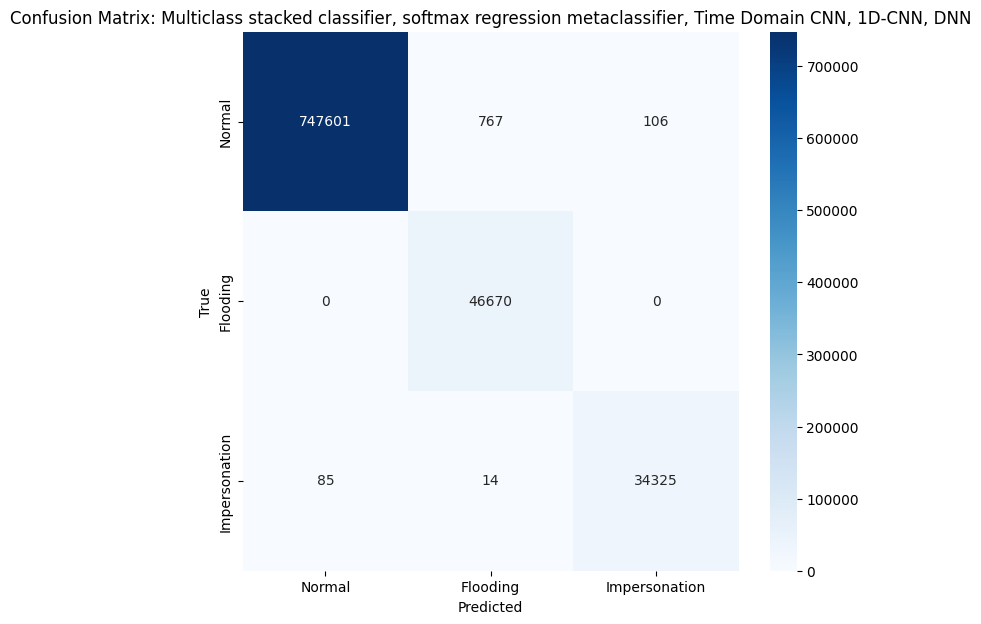

In [18]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_softmax_regression2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_softmax_regression2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, softmax regression metaclassifier, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [19]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training of base classifiers
for bc in mul_base_classifiers:
    bc.trainable=False

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 5

mul_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_dnn_classifier2.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      7,531 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, None, 3)   │      2,051 │ input_layer_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, None, 3)   │      9,083 │ input_layer_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 9)   │          0 │ sequential[3][0], │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, None, 4)   │         40 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, None, 3)   │         15 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,740 (73.20 KB)

 Trainable params: 75 (300.00 B)

 Non-trainable params: 18,665 (72.91 KB)

Epoch 1/5
    299/Unknown 49s 105ms/step - accuracy: 0.9029 - loss: 0.0554 - precision: 0.8690 - recall: 0.4655

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


299/299 ━━━━━━━━━━━━━━━━━━━━ 91s 245ms/step - accuracy: 0.9029 - loss: 0.0553 - precision: 0.8694 - recall: 0.4664 - val_accuracy: 0.9027 - val_loss: 0.0150 - val_precision: 0.9991 - val_recall: 0.9017
Epoch 2/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 95s 282ms/step - accuracy: 0.9608 - loss: 0.0112 - precision: 0.9980 - recall: 0.9100 - val_accuracy: 0.9672 - val_loss: 0.0083 - val_precision: 0.9987 - val_recall: 0.9670
Epoch 3/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 99s 286ms/step - accuracy: 0.9856 - loss: 0.0045 - precision: 0.9980 - recall: 0.9836 - val_accuracy: 0.9986 - val_loss: 0.0022 - val_precision: 0.9987 - val_recall: 0.9978
Epoch 4/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 100s 289ms/step - accuracy: 0.9984 - loss: 0.0013 - precision: 0.9990 - recall: 0.9974 - val_accuracy: 0.9984 - val_loss: 0.0011 - val_precision: 0.9986 - val_recall: 0.9980
Epoch 5/5
299/299 ━━━━━━━━━━━━━━━━━━━━ 98s 296ms/step - accuracy: 0.9987 - loss: 7.3041e-04 - precision: 0.9991 - recall: 0.9981 - val_accuracy: 0.9984 - val_los

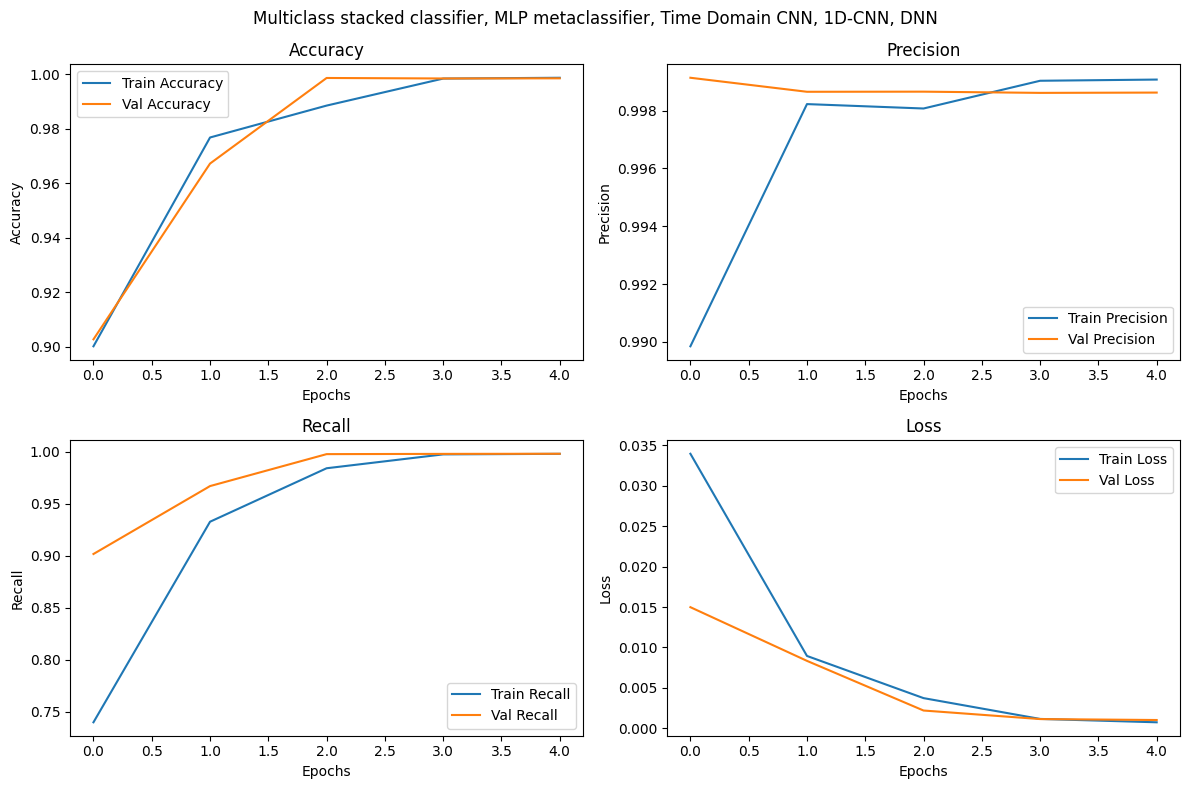

In [20]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files[:15])
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)

history = mul_dnn_classifier2.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass stacked classifier, MLP metaclassifier, Time Domain CNN, 1D-CNN, DNN')

203/203 ━━━━━━━━━━━━━━━━━━━━ 108s 267ms/step
Accuracy: 99.869%
Precision: 99.238%
Recall: 99.862%
F1 : 0.99547
Kappa: 0.99282


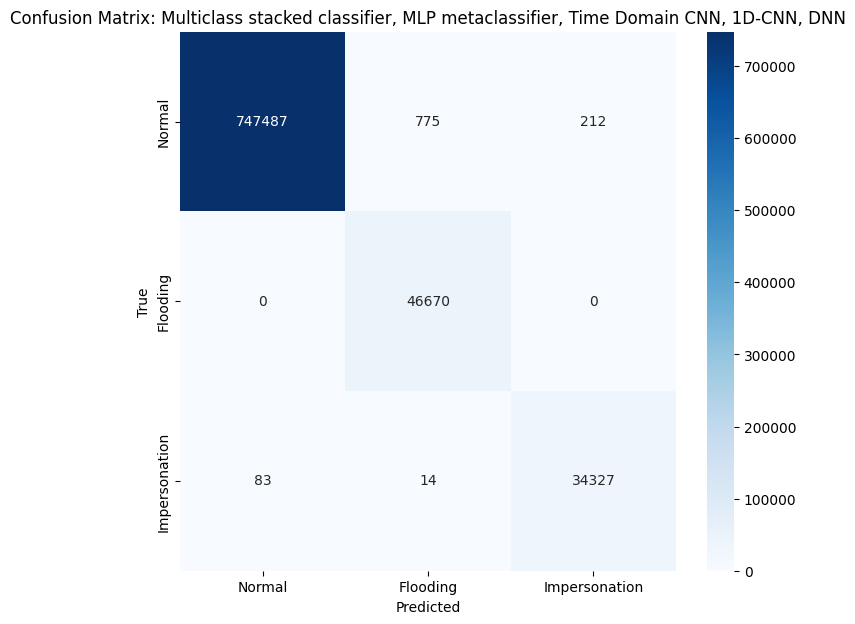

In [21]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_classifier2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_dnn_classifier2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, MLP metaclassifier, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

|                       | Accuracy | Precision | Recall  | F1      | Kappa   |
|-----------------------|----------|-----------|---------|---------|---------|
| Time Domain CNN       | 96.971%  | 78.809%   | 69.121% | 0.7053  | 0.7790  |
| 1D-CNN                | 98.807%  | 93.063%   | 99.281% | 0.9593  | 0.9253  |
| DNN                   | 98.873%  | 94.268%   | 99.370% | 0.9659  | 0.9292  |
| Arithmetic mean       | 98.911%  | 94.568%   | 99.221% | 0.9667  | 0.9314  |
| Improvement from best |  0.038%  |  0.300%   | -0.149% | 0.0008  | 0.0022  |
| F1 weighted mean      | 98.565%  | 90.508%   | 99.200% | 0.9450  | 0.9114  |
| Improvement from best | -0.308%  | -4.360%   | -0.170% | -0.0209 | -0.0176 |
| Kappa weighted mean   | 98.818%  | 93.667%   | 99.203% | 0.9619  | 0.9259  |
| Improvement from best | -0.093%  | -0.601%   | -0.167% | -0.0040 | -0.0033 |
| Softmax regression    | 98.849%  | 93.633%   | 99.299% | 0.9624  | 0.9278  |
| Improvement from best | -0.044%  | -0.635%   | -0.167% | -0.0035 | -0.0024 |
| MLP                   | 98.948%  | 93.479%   | 99.422% | 0.9627  | 0.9336  |
| Improvement from best |  0.075%  | -0.789%   |  0.072% | -0.0032 | 0.0044  |